In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from numpy import inf
# from utils.evaluation import find_landfalling_tcs,tc_region

In [2]:
def find_storm_extent(lat,lon,storm):

    lat_lower_bound = (np.abs(lat-np.min(storm.storm_lats))).argmin()
    lat_upper_bound = (np.abs(lat-np.max(storm.storm_lats))).argmin()
    lon_lower_bound = (np.abs(lon-np.min(storm.storm_lons))).argmin()
    lon_upper_bound = (np.abs(lon-np.max(storm.storm_lons))).argmin()

    lats = lat[lat_lower_bound:lat_upper_bound+2]
    lons = lon[lon_lower_bound:lon_upper_bound+2]
    grid_x, grid_y = np.meshgrid(lons,lats)
    return grid_x,grid_y


In [3]:
def ets_pred(pred_rain,truth_rain):
    threshold = np.percentile(truth_rain, 90)
    rain_bool = pred_rain > threshold
    # rain_grid_x = grid_X[rain_bool]

    rain_bool_truth = truth_rain > threshold
    # rain_grid_x_truth = grid_X[rain_bool_truth]

    hit = (rain_bool == True) & (rain_bool_truth == True)
    miss = (rain_bool == False) & (rain_bool_truth == True)
    hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))


    false_alarm = (rain_bool == True) & (rain_bool_truth == False)
    correct_rejection = (rain_bool == False) & (rain_bool_truth == False)
    false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))

    n_forecast_points = np.sum(rain_bool == True)
    n_observed_points = np.sum(rain_bool_truth == True)
    total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
    E = (n_forecast_points*n_observed_points) / total_points_possible

    ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)


    return hit_rate,false_alarm_rate,ETS
    # The number of forecasts of the event correct by chance, a r , is determined by assuming that the forecasts are totally independent of the observations, and forecast will match the observation only by chance. This is one form of an unskilled forecast, which can be generated by just guessing what will happen. The ETS has a range of -1/3 to 1, but the minimum value depends on the verification sample climatology. For rare events, the minimum ETS value is near 0, while the absolute minimum is obtained if the event has a climatological frequency of 0.5, and there are no hits. If the score goes below 0 then the chance forecast is preferred to the actual forecast, and the forecast is said to be unskilled.


In [4]:
def get_ets_scores(pred_rain_all,truth_rain_all):
    ntime,_,_,_ = pred_rain_all.shape
    hit_rates = np.zeros((ntime,20))
    false_alarm_rates = np.zeros((ntime,20))
    ETSs = np.zeros((ntime,20))
    for t in range(ntime):
        for e in range(20):
            hit_rate,false_alarm_rate,ETS = ets_pred(pred_rain_all[t,:,:,e],truth_rain_all[t,:,:,0])
            hit_rates[t,e] = hit_rate
            false_alarm_rates[t,e] = false_alarm_rate
            ETSs[t,e] = ETS
    return hit_rates,false_alarm_rates,ETSs

In [5]:
def crop_blob(array_to_crop,boolean_array):
    # Find indices of True values along rows and columns
    true_rows, true_cols = np.where(boolean_array)

    # Determine boundaries of the blob
    top = true_rows.min()
    bottom = true_rows.max()
    left = true_cols.min()
    right = true_cols.max()

    # Crop the array
    # print(array_to_crop.shape)
    # print(top,bottom,left,right)
    cropped_array = array_to_crop[top:bottom+1, left:right+1]

    return cropped_array

In [6]:
def exposure_calc(population, rain,threshold):
	""" number of people exposed to over 200mm in New York"""
	# population[rain['precipitation'] < 200] = 0
	# print('max rain',np.max(rain['precipitation'].values))
	print('max rain',np.max(rain))
	# population = population.where(rain['precipitation'].values > threshold,0)
	population = population.where(rain > threshold,0)
	# exposure = np.nansum(population['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2])
	pop = population.population.values
	pop[pop == -inf] = 0
	exposure = np.nansum(pop)
	return exposure

In [7]:
def ets(total_storm_rain,total_storm_rain_truth,pop,threshold=50,silent=False):

	# if silent == True:
	# 	sys.stdout = StringIO()

	rain_bool = total_storm_rain > threshold
	# rain_grid_x = grid_X[rain_bool]

	rain_bool_truth = total_storm_rain_truth > threshold
	# rain_grid_x_truth = grid_X[rain_bool_truth]

	hit = (rain_bool == True) & (rain_bool_truth == True)
	miss = (rain_bool == False) & (rain_bool_truth == True)
	hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))
	# print('Hit rate: ',hit_rate*100)

	# population
	pop_hit = np.sum(pop[hit])
	pop_miss = np.sum(pop[miss])
	pop_hit_rate = pop_hit / (pop_hit + pop_miss)
	# pop_hit_rate = pop_hit
	datapop = np.copy(pop)
	datapop[~hit] = 0
	# print('pop hits',np.sum(datapop))


	false_alarm = (rain_bool == True) & (rain_bool_truth == False)
	correct_rejection_1 = (rain_bool == False) & (rain_bool_truth == False)
	rain_bool_truth_crop = crop_blob(rain_bool_truth,rain_bool_truth)
	rain_bool_crop = crop_blob(rain_bool,rain_bool_truth)
	correct_rejection = (rain_bool_crop == False) & (rain_bool_truth_crop == False)
	false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))
	# print('false alarm rate',false_alarm_rate*100)

	pop_false_alarm = np.sum(pop[false_alarm])
	# print('pop_false alarm', pop_false_alarm)
	# pop_correct_rejection_1 = np.sum(pop[correct_rejection_1])
	# pop_correct_rejection_1 = pop[correct_rejection_1]
	# print('shape',pop_correct_rejection_1.shape)
	# print('shape',correct_rejection_1.shape)
	# print(pop.shape)
	crop_pop = crop_blob(pop,rain_bool_truth)
	pop_correct_rejection = np.sum(crop_pop[correct_rejection])
	# print(pop_correct_rejection)
	pop_false_alarm_rate = pop_false_alarm / (pop_false_alarm + pop_correct_rejection + 1)
	# print(pop_false_alarm_rate)
	if np.isnan(pop_false_alarm_rate):
		# print(pop_false_alarm_rate)
		# print(pop_false_alarm)
		# print(pop_correct_rejection)
		exit()
	# pop_false_alarm_rate = pop_false_alarm

	# equitable threat score is:
	# (hit - random chance) / (the observed rain area exceeding the criterion + model precticted area - hit - random chance)
	# where R = the observed rain area exceeding the criterion * (model predicted area / entire verification domain)
	# http://cimss.ssec.wisc.edu/goes/comet/threat.html
	# ETS = (hits - E) / (hits + misses + false alarms - E)
	# E = (number of forecast points * number of observed points) / total number of points possible

	n_forecast_points = np.sum(rain_bool == True)
	n_observed_points = np.sum(rain_bool_truth == True)
	total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
	E = (n_forecast_points*n_observed_points) / total_points_possible
	ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)
	# print('ETS: ', ETS)

	n_fp_pop = np.sum(pop[rain_bool])
	n_obs_pop = np.sum(pop[rain_bool_truth])
	bool = (rain_bool_truth == True) | (rain_bool_truth == False)
	total_pp_pop = np.sum(pop[bool])
	E_pop = (n_fp_pop*n_obs_pop) / total_pp_pop
	ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)
	# print(ETS_pop)
	# if silent == True:
	# 	sys.stdout = sys.__stdout__ 
	return hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate
	# The number of forecasts of the event correct by chance, a r , is determined by assuming that the forecasts are totally independent of the observations, and forecast will match the observation only by chance. This is one form of an unskilled forecast, which can be generated by just guessing what will happen. The ETS has a range of -1/3 to 1, but the minimum value depends on the verification sample climatology. For rare events, the minimum ETS value is near 0, while the absolute minimum is obtained if the event has a climatological frequency of 0.5, and there are no hits. If the score goes below 0 then the chance forecast is preferred to the actual forecast, and the forecast is said to be unskilled.


In [8]:
precip_cmap,precip_norm = make_cmap()
levels = [10, 15, 20, 25, 30, 40, 50,75, 100]

In [9]:
meta = pd.read_csv('/user/work/al18709/tc_data_mswep_40/modular_wgan_extreme_valid_meta_with_dates.csv')
meta2 = pd.read_csv('/user/work/al18709/tc_data_flipped/extreme_valid_meta.csv')
# meta2 = pd.read_csv('/user/work/al18709/tc_data_mswep_40/scalar_wgan_extreme_valid_meta_with_dates.csv')
meta3 = pd.read_csv('/user/work/al18709/tc_data_mswep_40/scalar_wgan_extreme_valid_meta_with_dates.csv')

In [10]:
meta = pd.read_csv('/user/work/al18709/tc_data_mswep_40/modular_wgan_valid_meta_with_dates.csv')
meta2 = pd.read_csv('/user/work/al18709/tc_data_flipped/valid_meta.csv')
# meta2 = pd.read_csv('/user/work/al18709/tc_data_mswep_40/scalar_wgan_validation_meta_with_dates.csv')
meta3 = pd.read_csv('/user/work/al18709/tc_data_mswep_40/scalar_wgan_valid_meta_with_dates.csv')

In [11]:
print(meta)


       Unnamed: 0.1  Unnamed: 0            sid  centre_lat  centre_lon  \
0                 0           0  1979002S04179    -19.6795    152.1280   
1                 1           1  1979002S04179    -19.5816    152.6000   
2                 2           2  1979002S04179    -19.5087    153.0150   
3                 3           3  1979002S04179    -19.4371    153.4180   
4                 4           4  1979002S04179    -19.3841    160.4130   
...             ...         ...            ...         ...         ...   
15925         15925       15925  2020291N32305     44.0804    -49.5136   
15926         15926       15926  2020291N32305     45.0000    -46.9000   
15927         15927       15927  2020291N32305     46.0484    -44.1609   
15928         15928       15928  2020291N32305     47.2000    -41.2000   
15929         15929       15929  2020291N32305     48.3182    -37.9752   

                      date  
0      1979-01-11 00:00:00  
1      1979-01-10 21:00:00  
2      1979-01-10 18:00:

In [12]:
print(meta2)

       Unnamed: 0            sid  centre_lat  centre_lon
0               0  1979002S04179    -19.6795    152.1280
1               1  1979002S04179    -19.5816    152.6000
2               2  1979002S04179    -19.5087    153.0150
3               3  1979002S04179    -19.4371    153.4180
4               4  1979002S04179    -19.3841    160.4130
...           ...            ...         ...         ...
15925       15925  2020291N32305     44.0804    -49.5136
15926       15926  2020291N32305     45.0000    -46.9000
15927       15927  2020291N32305     46.0484    -44.1609
15928       15928  2020291N32305     47.2000    -41.2000
15929       15929  2020291N32305     48.3182    -37.9752

[15930 rows x 4 columns]


In [13]:
print(meta3)

       Unnamed: 0.1  Unnamed: 0            sid  centre_lat  centre_lon  \
0                 0           0  1979002S04179    -19.6795    152.1280   
1                 1           1  1979002S04179    -19.5816    152.6000   
2                 2           2  1979002S04179    -19.5087    153.0150   
3                 3           3  1979002S04179    -19.4371    153.4180   
4                 4           4  1979002S04179    -19.3841    160.4130   
...             ...         ...            ...         ...         ...   
15925         15925       15925  2020291N32305     44.0804    -49.5136   
15926         15926       15926  2020291N32305     45.0000    -46.9000   
15927         15927       15927  2020291N32305     46.0484    -44.1609   
15928         15928       15928  2020291N32305     47.2000    -41.2000   
15929         15929       15929  2020291N32305     48.3182    -37.9752   

                      date  
0      1979-01-11 00:00:00  
1      1979-01-10 21:00:00  
2      1979-01-10 18:00:

In [14]:
# open storm dataset

# define filenames and paths
tc_dir = '/user/home/al18709/work/event_sets/wgan_modular/'
tc_dir_p = '/user/home/al18709/work/event_sets/patchgan/'
tc_dir_truth = '/user/home/al18709/work/event_sets/truth/'
storm = '2006237N13298'
data_set = 'validation'
storm_filename = f'{data_set}_mraw_{storm}.nc'
storm_filename2 = f'{data_set}_1and2_{storm}.nc'
# storm_filename_p = f'{data_set}_patchgan_{storm}.nc'

# load storm scores
storm_scores = np.load(tc_dir + f'{data_set}_mraw_critic_{storm}.npy')
storm_scores2 = np.load(tc_dir + f'{data_set}_1and2_critic_{storm}.npy')
storm_scores_p = np.load(tc_dir_p + f'patchgan_critic_{storm}.npy')
print(storm_scores.shape)
print(storm_scores_p.shape)

# load rain data
storm = xr.open_dataset(tc_dir + storm_filename)
storm2 = xr.open_dataset(tc_dir + storm_filename2)
storm_truth = xr.open_dataset(tc_dir_truth + f'validation_2006237N13298.nc')

# idai or amphan
ETS_scores = get_ets_scores(storm2.precipitation.values,storm_truth.precipitation.values)


(45, 1, 20)
(45, 1, 20)


In [15]:
# define initial variables
precip_cmap,precip_norm = make_cmap()

lats = storm.storm_lats[0,:,:]
lons = storm.storm_lons[0,:,:]

levels = [10, 15, 20, 25, 30, 40, 50, 75, 100]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=100
ntime,_,_,_ = storm.precipitation.shape

rain = storm.precipitation[0,:,:,0]
rain2 = storm2.precipitation[0,:,:,0]
rain_truth = storm_truth.precipitation[0,:,:,0]


In [16]:
# find storm extent
fp = '/bp1/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
d = Dataset(fp, 'r')
lat = d.variables['lat'][:] #lat
lon = d.variables['lon'][:] #lon
lat_lower_bound = (np.abs(lat-np.min(storm.storm_lats))).argmin()
lat_upper_bound = (np.abs(lat-np.max(storm.storm_lats))).argmin()
lon_lower_bound = (np.abs(lon-np.min(storm.storm_lons))).argmin()
lon_upper_bound = (np.abs(lon-np.max(storm.storm_lons))).argmin()

lats = lat[lat_lower_bound:lat_upper_bound+2]
lons = lon[lon_lower_bound:lon_upper_bound+2]
grid_x, grid_y = np.meshgrid(lons,lats)
print(grid_x.shape)
print(grid_y.shape)

(326, 252)
(326, 252)


In [17]:
# superimpose rain onto bigger grid
grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))
grid_rain2 = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))
grid_rain_combo = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1]))
grid_rain_truth = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1]))

for t in range(ntime):

	storm_lons = storm.storm_lons[t,:,:]
	storm_lats = storm.storm_lats[t,:,:]
	
	storm_rain_truth = storm_truth.precipitation[t,:,:,0]

	Mlon = storm_lons[-1,-1]
	mlon = storm_lons[0,0]
	Mlat = storm_lats[-1,-1]
	mlat = storm_lats[0,0]
	Xspan = np.where((grid_x <= Mlon) & (grid_x >= mlon))[1][[0, -1]]
	Yspan = np.where((grid_y <= Mlat) & (grid_y >= mlat))[0][[0, -1]]

	# Create a selection
	sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]
	# sel = [slice(Xspan[0] - 1, Xspan[1]), slice(Yspan[0] - 1, Yspan[1])]
	# sel = [slice(Yspan[0] -1, Yspan[1] + 1), slice(Xspan[0]-1, Xspan[1] + 1)]

	# grid_rain[t,sel[0],sel[1]] = storm_rain
	for i in range(20):
		storm_rain = storm.precipitation[t,:,:,i]
		grid_rain[t,sel[1],sel[0],i] = storm_rain
		storm_rain2 = storm2.precipitation[t,:,:,i]
		grid_rain2[t,sel[1],sel[0],i] = storm_rain2
		

	grid_rain_truth[t,sel[1],sel[0]] = storm_rain_truth
	

In [18]:
total_storm_rain = np.sum(grid_rain[:,:,:,0],axis=0)
total_storm_rain2 = np.sum(grid_rain2[:,:,:,0],axis=0)

total_storm_rain_truth = np.sum(grid_rain_truth,axis=0)
rain_bool = total_storm_rain > 50
rain_bool2 = total_storm_rain2 > 50

print(np.sum(rain_bool))
rain_grid_x2 = grid_x[rain_bool2]


rain_bool_truth = total_storm_rain_truth > 50
print(np.sum(rain_bool_truth))
rain_grid_x_truth = grid_x[rain_bool_truth]

4926
5084


In [19]:
# hit = (rain_bool == True) & (rain_bool_truth == True)
# print(np.sum(hit))
# miss = (rain_bool == False) & (rain_bool_truth == True)
# hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))
# print('Hit rate: ',hit_rate*100)

# false_alarm = (rain_bool == True) & (rain_bool_truth == False)
# correct_rejection = (rain_bool == False) & (rain_bool_truth == False)
# false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))
# print('false alarm rate',false_alarm_rate*100)

# hit2 = (rain_bool2 == True) & (rain_bool_truth == True)
# print(np.sum(hit))
# miss2 = (rain_bool2 == False) & (rain_bool_truth == True)
# hit_rate2 = np.sum(hit2) / (np.sum(hit2) + np.sum(miss2))
# print('Hit rate2: ',hit_rate2*100)

# false_alarm2 = (rain_bool2 == True) & (rain_bool_truth == False)
# correct_rejection2 = (rain_bool2 == False) & (rain_bool_truth == False)
# false_alarm_rate2 = np.sum(false_alarm2)/(np.sum(false_alarm2) + np.sum(correct_rejection2))
# print('false alarm rate2',false_alarm_rate2*100)

# hit3 = (rain_bool3 == True) & (rain_bool_truth == True)
# print(np.sum(hit))
# miss3 = (rain_bool3 == False) & (rain_bool_truth == True)
# hit_rate3 = np.sum(hit2) / (np.sum(hit3) + np.sum(miss3))
# print('Hit rate3: ',hit_rate3*100)

# false_alarm3 = (rain_bool3 == True) & (rain_bool_truth == False)
# correct_rejection3 = (rain_bool3 == False) & (rain_bool_truth == False)
# false_alarm_rate3 = np.sum(false_alarm3)/(np.sum(false_alarm3) + np.sum(correct_rejection3))
# print('false alarm rate3',false_alarm_rate3*100)

# hit4 = (rain_bool4 == True) & (rain_bool_truth == True)
# print(np.sum(hit))
# miss4 = (rain_bool4 == False) & (rain_bool_truth == True)
# hit_rate4 = np.sum(hit4) / (np.sum(hit4) + np.sum(miss4))
# print('Hit rate4: ',hit_rate4*100)

# false_alarm4 = (rain_bool4 == True) & (rain_bool_truth == False)
# correct_rejection4 = (rain_bool4 == False) & (rain_bool_truth == False)
# false_alarm_rate4 = np.sum(false_alarm4)/(np.sum(false_alarm4) + np.sum(correct_rejection4))
# print('false alarm rate4',false_alarm_rate4*100)

# # equitable threat score is:
# # (hit - random chance) / (the observed rain area exceeding the criterion + model precticted area - hit - random chance)
# # where R = the observed rain area exceeding the criterion * (model predicted area / entire verification domain)
# # http://cimss.ssec.wisc.edu/goes/comet/threat.html
# # ETS = (hits - E) / (hits + misses + false alarms - E)
# # E = (number of forecast points * number of observed points) / total number of points possible

# n_forecast_points = np.sum(rain_bool == True)
# n_observed_points = np.sum(rain_bool_truth == True)
# total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
# E = (n_forecast_points*n_observed_points) / total_points_possible
# ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)
# print('ETS: ', ETS)


# n_forecast_points2 = np.sum(rain_bool2 == True)
# n_observed_points2 = np.sum(rain_bool_truth == True)
# total_points_possible2 = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
# E = (n_forecast_points2*n_observed_points2) / total_points_possible2
# ETS = (np.sum(hit2) - E) / (np.sum(hit2) + np.sum(miss2) + np.sum(false_alarm2) - E)
# print('ETS2: ', ETS)

# n_forecast_points3 = np.sum(rain_bool3 == True)
# n_observed_points3 = np.sum(rain_bool_truth == True)
# total_points_possible3 = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
# E = (n_forecast_points3*n_observed_points3) / total_points_possible3
# ETS = (np.sum(hit3) - E) / (np.sum(hit3) + np.sum(miss3) + np.sum(false_alarm3) - E)
# print('ETS3: ', ETS)

# n_forecast_points4 = np.sum(rain_bool4 == True)
# n_observed_points4 = np.sum(rain_bool_truth == True)
# total_points_possible4 = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
# E = (n_forecast_points4*n_observed_points4) / total_points_possible4
# ETS = (np.sum(hit4) - E) / (np.sum(hit4) + np.sum(miss4) + np.sum(false_alarm4) - E)
# print('ETS4: ', ETS)
# # The number of forecasts of the event correct by chance, a r , is determined by assuming that the forecasts are totally independent of the observations, and forecast will match the observation only by chance. This is one form of an unskilled forecast, which can be generated by just guessing what will happen. The ETS has a range of -1/3 to 1, but the minimum value depends on the verification sample climatology. For rare events, the minimum ETS value is near 0, while the absolute minimum is obtained if the event has a climatological frequency of 0.5, and there are no hits. If the score goes below 0 then the chance forecast is preferred to the actual forecast, and the forecast is said to be unskilled.

In [20]:
accumulated_rain = np.sum(grid_rain,axis=0)
accumulated_rain2 = np.sum(grid_rain2,axis=0)

In [21]:
population_file = '/user/home/al18709/work/population/ppp_2020_10km_Aggregated_final.nc'
population_count = xr.load_dataset(population_file)
print(population_count)
data = population_count.population.values * 144
population = population_count.population.values * 144
pop = population_count * 144


pop_lats = population_count.lat
pop_lons = population_count.lon
grid_x_pop, grid_y_pop = np.meshgrid(pop_lons,pop_lats)

<xarray.Dataset>
Dimensions:     (lon: 3600, lat: 1800)
Coordinates:
  * lon         (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat         (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    population  (lat, lon) float32 -3.403e+38 -3.403e+38 ... -3.403e+38
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Nov 01 12:12:14 2023: cdo remapnn,mygrid /user/home/al1...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


/tmp/ipykernel_204363/1317023007.py:4: RuntimeWarning: overflow encountered in multiply
  data = population_count.population.values * 144
/tmp/ipykernel_204363/1317023007.py:5: RuntimeWarning: overflow encountered in multiply
  population = population_count.population.values * 144


In [22]:
# exposure
# storm_pop = pop.sel(lat=slice(-lats[-1]+1+12,-lats[0]+12), lon=slice(lons[0],lons[-1]+1))
# print(storm_pop)
# storm_pop_data = storm_pop.population.values
# print(storm_pop_data.shape)
# print(np.sum(grid_rain,axis=0).shape)
# print(grid_x.shape)
print(pop.population.shape)
accumulated_rain = np.sum(grid_rain[:,:,:,0],axis=0)
accumulated_rain2 = np.sum(grid_rain2[:,:,:,0],axis=0)
accumulated_rain_truth = np.sum(grid_rain_truth,axis=0)


# superimpose rain onto bigger grid
n_time_steps,n,m,_ = grid_rain2.shape
combo_rain = np.zeros((n_time_steps,n,m))
combo_rain_p = np.zeros((n_time_steps,n,m))
max_rain = np.zeros((n_time_steps,n,m))
ets_rain = np.zeros((n_time_steps,n,m))
print(storm_scores.shape)
for t in range(n_time_steps):
	t_scores = storm_scores2[t,:]
	best_score = np.argmax(t_scores)
	t_scores_p = storm_scores_p[t,:]
	best_score_p = np.argmax(t_scores_p)
	combo_rain[t,:,:] = grid_rain2[t,:,:,best_score]
	combo_rain_p[t,:,:] = grid_rain2[t,:,:,best_score_p]
	max_idx = np.argmax(np.sum(grid_rain2[t,:,:,:],axis=(0,1)))
	max_rain[t,:,:] = grid_rain2[t,:,:,max_idx]
	ets_idx = np.argmax(ETS_scores[-1][t,:])
	ets_rain[t,:,:] = grid_rain2[t,:,:,ets_idx]

global_rain = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain2 = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain_combo = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain_combo_p = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain_max = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain_ets = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain_truth = np.zeros((pop.population.shape[0],pop.population.shape[1]))

storm_lons = grid_x
storm_lats = grid_y
storm_rain = accumulated_rain
storm_rain2 = accumulated_rain2
storm_rain_combo = np.sum(combo_rain,axis=0)
storm_rain_combo_p = np.sum(combo_rain,axis=0)
storm_rain_max = np.sum(max_rain,axis=0)
storm_rain_ets = np.sum(ets_rain,axis=0)
storm_rain_truth = accumulated_rain_truth

Mlon = storm_lons[-1,-1]
mlon = storm_lons[0,0]
Mlat = storm_lats[-1,-1]
mlat = storm_lats[0,0]
grid_X,grid_Y = np.meshgrid(lon,lat)
Xspan = np.where((grid_X <= Mlon) & (grid_X >= mlon))[1][[0, -1]]
Yspan = np.where((grid_Y <= Mlat) & (grid_Y >= mlat))[0][[0, -1]]

# Create a selection
sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]



global_rain[sel[1],sel[0]] = storm_rain
global_rain2[sel[1],sel[0]] = storm_rain2
global_rain_combo[sel[1],sel[0]] = storm_rain_combo
global_rain_combo_p[sel[1],sel[0]] = storm_rain_combo_p
global_rain_max[sel[1],sel[0]] = storm_rain_max
global_rain_ets[sel[1],sel[0]] = storm_rain_ets
global_rain_truth[sel[1],sel[0]] = storm_rain_truth



pred_exposure = exposure_calc(pop,global_rain,150)
truth_exposure = exposure_calc(pop,global_rain_truth,150)


(1800, 3600)
(45, 1, 20)
max rain 252.54801664183464
max rain 334.8124869460173


In [23]:
# print(max_rain[t,:,:].shape)
# print(grid_rain2[t,:,:,max_idx[t]].shape)
# print(max_idx.shape)

In [24]:

global_pop = pop.population.values

global_pop[global_pop == -inf] = 0
pop_new = global_pop[::-1, :]

blank_rows = np.zeros((120, pop_new.shape[1]))  # Create an array of zeros with the same number of columns as arr
pop_new_new = np.insert(pop_new, 0, blank_rows, axis=0)
global_pop_new = pop_new_new[:-120,:]



In [25]:
thresh = 100
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(global_rain2,global_rain_truth,global_pop_new,threshold=thresh)

hit_rate2,false_alarm_rate2,ETS2,pop_hit2,pop_miss2,pop_hit_rate2,pop_false_alarm2,pop_correct_rejection2,pop_false_alarm_rate2 = ets(global_rain_combo,global_rain_truth,global_pop_new,threshold=thresh)

hit_rate_p,false_alarm_rate_p,ETS_p,pop_hit_p,pop_miss_p,pop_hit_rate_p,pop_false_alarm_p,pop_correct_rejection_p,pop_false_alarm_rate_p = ets(global_rain_combo_p,global_rain_truth,global_pop_new,threshold=thresh)


In [26]:
# n_time_steps,n,m,_ = grid_rain2.shape
# combo_rain = np.zeros((n_time_steps,n,m))
# print(storm_scores.shape)
# for t in range(n_time_steps):
# 	t_scores = storm_scores2[t,:]
# 	best_score = np.argmax(t_scores)
# 	combo_rain[t,:,:] = grid_rain2[t,:,:,best_score]

# ensemble_combo = np.sum(combo_rain,axis=0)
print(t_scores)
# print(ensemble_combo.shape)

[[35.48645401 34.12951279 34.47383118 35.14020157 35.20592499 36.31818771
  35.4320488  34.88246155 34.82857132 35.10952377 35.22514343 34.20941925
  35.37328339 33.54793167 35.29053879 33.92079544 35.09925842 33.99691391
  34.4142952  33.97906876]]


In [27]:
# TODO 
# the question is, what level of extreme rainfall can we be confident in calculating the exposure to?
# how often are we wrong when it's 50mm,100mm,150mm
# how often are we right?
# do the ensemble combining method with critic score so best of 20 images are selected


In [28]:
# # levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
# # sns.set_style("white")
# # sns.set_context("notebook")
# # vmin=-2
# # vmax=2

# # TODO: add in combination of ensemble members. Not the mean, but based on the critic score of each image - e.g. the ones which are the best quality are the ones we select

# levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
# sns.set_style("white")
# sns.set_context("notebook")
# vmin=0
# vmax=300


# fig, axes = plt.subplots(2,5,figsize=(28,16),subplot_kw={'projection': ccrs.PlateCarree()})

# rain1 = np.sum(grid_rain2[:,:,:,0],axis=0) > 50
# rain2 = np.sum(grid_rain_truth,axis=0) > 50
# hit = (rain1 == True) & (rain2 == True)
# miss = (rain1 == False) & (rain2 == True)
# false_alarm = (rain1 == True) & (rain2 == False)
# correct_rejection = (rain1 == False) & (rain2 == False)
# rain_data_mwgan_parts12 = hit + 2* miss + 3* false_alarm + 4*correct_rejection

# rain1 = storm_rain_combo > 50
# rain2 = np.sum(grid_rain_truth,axis=0) > 50
# hit = (rain1 == True) & (rain2 == True)
# miss = (rain1 == False) & (rain2 == True)
# false_alarm = (rain1 == True) & (rain2 == False)
# correct_rejection = (rain1 == False) & (rain2 == False)
# rain_data_combo = hit + 2* miss + 3* false_alarm + 4*correct_rejection

# rain1 = storm_rain_max > 50
# rain2 = np.sum(grid_rain_truth,axis=0) > 50
# hit = (rain1 == True) & (rain2 == True)
# miss = (rain1 == False) & (rain2 == True)
# false_alarm = (rain1 == True) & (rain2 == False)
# correct_rejection = (rain1 == False) & (rain2 == False)
# rain_data_max = hit + 2* miss + 3* false_alarm + 4*correct_rejection

# rain1 = storm_rain_ets > 50
# rain2 = np.sum(grid_rain_truth,axis=0) > 50
# hit = (rain1 == True) & (rain2 == True)
# miss = (rain1 == False) & (rain2 == True)
# false_alarm = (rain1 == True) & (rain2 == False)
# correct_rejection = (rain1 == False) & (rain2 == False)
# rain_data_ets = hit + 2* miss + 3* false_alarm + 4*correct_rejection

# # Create a colormap with distinct colors
# colors = ['white', '#A3C9A9', '#C9A9A3', '#f2cc8f','white']
# cmap = mcolors.ListedColormap(colors)

# # Create color boundaries
# bounds = np.arange(1, 5, 1)

# # Create a BoundaryNorm instance
# norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')
# # norm = mcolors.BoundaryNorm(bounds, cmap.N)

# # first panel
# axes[0,0].contourf(grid_x,grid_y,np.sum(grid_rain2[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# # second panel
# axes[0,1].contourf(grid_x,grid_y,storm_rain_combo,vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# # third panel
# axes[0,2].contourf(grid_x,grid_y,storm_rain_max,vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# # fourth panel
# axes[0,3].contourf(grid_x,grid_y,storm_rain_ets,vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# # fifth panel
# m = axes[0,4].contourf(grid_x,grid_y,np.sum(grid_rain_truth,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# # sixth panel
# h = axes[1,0].pcolormesh(grid_x,grid_y,rain_data_mwgan_parts12,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

# # axes[1,1].contourf(grid_x,grid_y,np.sum(grid_rain2[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)
# # seventh panel
# h = axes[1,1].pcolormesh(grid_x,grid_y,rain_data_combo,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

# # eigth panel hit and miss mwgan part 1 and 2
# axes[1,2].pcolormesh(grid_x,grid_y,rain_data_max,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

# # ninth panel
# axes[1,3].pcolormesh(grid_x,grid_y,rain_data_ets,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

# # tenth panel
# stand_dev = np.std(np.sum(grid_rain2[:,:,:,:],axis=0),axis=-1)
# axes[1,4].contourf(grid_x,grid_y,stand_dev,vmin=0,vmax=40,levels=[0,5,10,15,20,30,40],cmap = 'Oranges', transform=ccrs.PlateCarree(),alpha=0.8)


# for i in range(5):
# 	for j in range(2):
# 		axes[j,i].add_feature(cfeature.COASTLINE,linewidth=0.5)
# 		axes[j,i].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


# 		# ax.outline_patch.set_linewidth(0.5)
# 		gl = axes[j,i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
# 					linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
# 		gl.xlabels_top = False
# 		gl.ylabels_right = False
# 		gl.xlabel_style = {'size': 12}
# 		gl.ylabel_style = {'size': 12}
# 		# ax.set_xticklabels(labelsize=20)
# 		# ax.set_yticklabels(labelsize=20)
# 		axes[j,i].tick_params(axis='x', labelsize=14)
# 		axes[j,i].tick_params(axis='y', labelsize=14)

# 	# precip_cmap,precip_norm = make_cmap(high_vals=True)
# 	# cbar = plt.colorbar(h, ticks=np.arange(0.5, 4.5, 1), boundaries=bounds, label='Rain Category')
# 		axes[j,i].set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
# 	# ax.set_title('Hit and Miss',fontsize=18,pad=15)

# axes[0,0].text(-0.1, 1.05, 'a.', transform=axes[0,0].transAxes, size=18, weight='bold')
# axes[0,1].text(-0.1, 1.05, 'b.', transform=axes[0,1].transAxes, size=18, weight='bold')
# axes[0,2].text(-0.1, 1.05, 'c.', transform=axes[0,2].transAxes, size=18, weight='bold')
# axes[0,3].text(-0.1, 1.05, 'd.', transform=axes[0,3].transAxes, size=18, weight='bold')
# axes[0,4].text(-0.1, 1.05, 'e.', transform=axes[0,4].transAxes, size=18, weight='bold')
# axes[1,0].text(-0.1, 1.05, 'f.', transform=axes[1,0].transAxes, size=18, weight='bold')
# axes[1,1].text(-0.1, 1.05, 'g.', transform=axes[1,1].transAxes, size=18, weight='bold')
# axes[1,2].text(-0.1, 1.05, 'h.', transform=axes[1,2].transAxes, size=18, weight='bold')
# axes[1,3].text(-0.1, 1.05, 'i.', transform=axes[1,3].transAxes, size=18, weight='bold')
# axes[1,4].text(-0.1, 1.05, 'j.', transform=axes[1,4].transAxes, size=18, weight='bold')
# legend_labels = ['LEGEND', 'Hit', 'Miss', 'False alarm','Correct rejection']
# legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for color, label in zip(colors, legend_labels)]
# axes[1,2].legend(handles=legend_handles, loc='upper right')

# axes[0,0].set_title('First ensemble member',fontsize=18,pad=10)
# axes[0,1].set_title('Critic combined ensemble',fontsize=18,pad=10)
# axes[0,2].set_title('Max ensemble',fontsize=18,pad=10)
# axes[0,3].set_title('ETS score',fontsize=18,pad=10)
# axes[0,4].set_title('Truth ',fontsize=18,pad=10)
# axes[1,0].set_title('First ensemble (<50 mm)',fontsize=18,pad=10)
# axes[1,1].set_title('Critic combined ensemble (<50 mm)',fontsize=18,pad=10)
# axes[1,2].set_title('Critic max ensemble (<50 mm)',fontsize=18,pad=10)
# axes[1,3].set_title('ETS ensemble (<50 mm)',fontsize=18,pad=10)
# axes[1,4].set_title('Standard deviation',fontsize=18,pad=10)

# # cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[0])
# # cbar.ax.tick_params(labelsize=8,width=0.5)
# # cbar.ax.tick_params(labelsize=20)

# # cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[1])
# # cbar.ax.tick_params(labelsize=8,width=0.5)
# # cbar.ax.tick_params(labelsize=20)


# plt.savefig('figure_7d_combination.png',bbox_inches='tight')

# # TODO: compare hit miss and ets of combined score vs max and first,second,third etc

# # TODO: rainfall is gamma distribution so std not that meaningful, so plot most probable rainfall (not mean) up to 95th percentile


/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


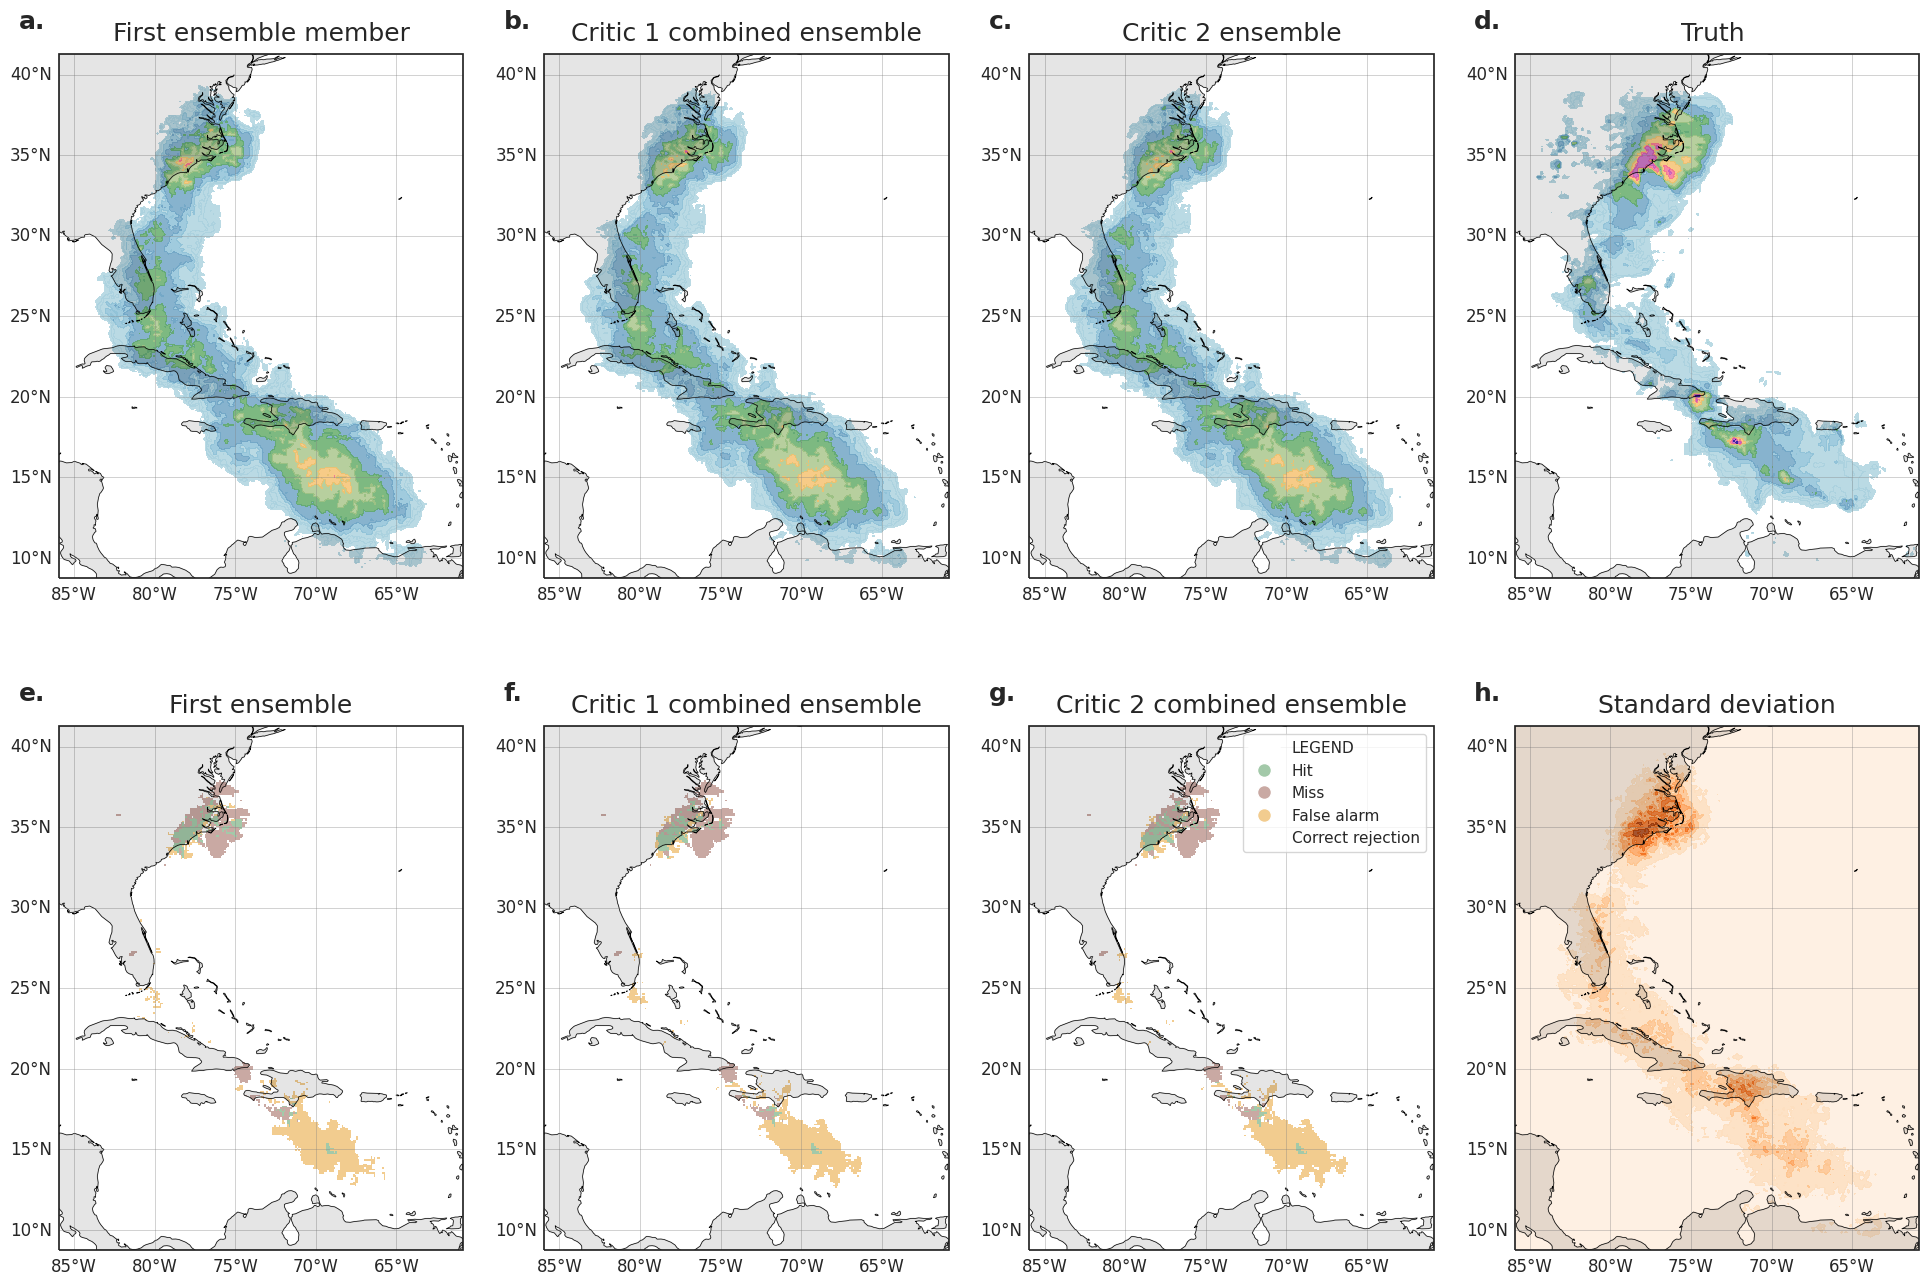

In [29]:
# levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
# sns.set_style("white")
# sns.set_context("notebook")
# vmin=-2
# vmax=2

# TODO: add in combination of ensemble members. Not the mean, but based on the critic score of each image - e.g. the ones which are the best quality are the ones we select

levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=300


fig, axes = plt.subplots(2,4,figsize=(24,16),subplot_kw={'projection': ccrs.PlateCarree()})

threshold = 100

rain1 = np.sum(grid_rain2[:,:,:,0],axis=0) > threshold
rain2 = np.sum(grid_rain_truth,axis=0) > threshold
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data_mwgan_parts12 = hit + 2* miss + 3* false_alarm + 4*correct_rejection

rain1 = storm_rain_combo > threshold
rain2 = np.sum(grid_rain_truth,axis=0) > threshold
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data_combo = hit + 2* miss + 3* false_alarm + 4*correct_rejection

rain1 = storm_rain_combo_p > threshold
rain2 = np.sum(grid_rain_truth,axis=0) > threshold
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data_combo_p = hit + 2* miss + 3* false_alarm + 4*correct_rejection

# rain1 = storm_rain_ets > 50
# rain2 = np.sum(grid_rain_truth,axis=0) > 50
# hit = (rain1 == True) & (rain2 == True)
# miss = (rain1 == False) & (rain2 == True)
# false_alarm = (rain1 == True) & (rain2 == False)
# correct_rejection = (rain1 == False) & (rain2 == False)
# rain_data_ets = hit + 2* miss + 3* false_alarm + 4*correct_rejection

# Create a colormap with distinct colors
colors = ['white', '#A3C9A9', '#C9A9A3', '#f2cc8f','white']
cmap = mcolors.ListedColormap(colors)

# Create color boundaries
bounds = np.arange(1, 5, 1)

# Create a BoundaryNorm instance
norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')
# norm = mcolors.BoundaryNorm(bounds, cmap.N)

# first panel
axes[0,0].contourf(grid_x,grid_y,np.sum(grid_rain2[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# second panel
axes[0,1].contourf(grid_x,grid_y,storm_rain_combo,vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# third panel
axes[0,2].contourf(grid_x,grid_y,storm_rain_combo_p,vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# fourth panel
# axes[0,3].contourf(grid_x,grid_y,storm_rain_ets,vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# fifth panel
m = axes[0,3].contourf(grid_x,grid_y,np.sum(grid_rain_truth,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# sixth panel
h = axes[1,0].pcolormesh(grid_x,grid_y,rain_data_mwgan_parts12,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

# axes[1,1].contourf(grid_x,grid_y,np.sum(grid_rain2[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)
# seventh panel
h = axes[1,1].pcolormesh(grid_x,grid_y,rain_data_combo,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

# eigth panel hit and miss mwgan part 1 and 2
axes[1,2].pcolormesh(grid_x,grid_y,rain_data_combo_p,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

# ninth panel
# axes[1,3].pcolormesh(grid_x,grid_y,rain_data_ets,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

# tenth panel
stand_dev = np.std(np.sum(grid_rain2[:,:,:,:],axis=0),axis=-1)
axes[1,3].contourf(grid_x,grid_y,stand_dev,vmin=0,vmax=40,levels=[0,5,10,15,20,30,40],cmap = 'Oranges', transform=ccrs.PlateCarree(),alpha=0.8)


for i in range(4):
	for j in range(2):
		axes[j,i].add_feature(cfeature.COASTLINE,linewidth=0.5)
		axes[j,i].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


		# ax.outline_patch.set_linewidth(0.5)
		gl = axes[j,i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
					linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
		gl.xlabels_top = False
		gl.ylabels_right = False
		gl.xlabel_style = {'size': 12}
		gl.ylabel_style = {'size': 12}
		# ax.set_xticklabels(labelsize=20)
		# ax.set_yticklabels(labelsize=20)
		axes[j,i].tick_params(axis='x', labelsize=14)
		axes[j,i].tick_params(axis='y', labelsize=14)

	# precip_cmap,precip_norm = make_cmap(high_vals=True)
	# cbar = plt.colorbar(h, ticks=np.arange(0.5, 4.5, 1), boundaries=bounds, label='Rain Category')
		axes[j,i].set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
	# ax.set_title('Hit and Miss',fontsize=18,pad=15)

axes[0,0].text(-0.1, 1.05, 'a.', transform=axes[0,0].transAxes, size=18, weight='bold')
axes[0,1].text(-0.1, 1.05, 'b.', transform=axes[0,1].transAxes, size=18, weight='bold')
axes[0,2].text(-0.1, 1.05, 'c.', transform=axes[0,2].transAxes, size=18, weight='bold')
axes[0,3].text(-0.1, 1.05, 'd.', transform=axes[0,3].transAxes, size=18, weight='bold')
# axes[0,4].text(-0.1, 1.05, 'e.', transform=axes[0,4].transAxes, size=18, weight='bold')
axes[1,0].text(-0.1, 1.05, 'e.', transform=axes[1,0].transAxes, size=18, weight='bold')
axes[1,1].text(-0.1, 1.05, 'f.', transform=axes[1,1].transAxes, size=18, weight='bold')
axes[1,2].text(-0.1, 1.05, 'g.', transform=axes[1,2].transAxes, size=18, weight='bold')
axes[1,3].text(-0.1, 1.05, 'h.', transform=axes[1,3].transAxes, size=18, weight='bold')
# axes[1,4].text(-0.1, 1.05, 'j.', transform=axes[1,4].transAxes, size=18, weight='bold')
legend_labels = ['LEGEND', 'Hit', 'Miss', 'False alarm','Correct rejection']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for color, label in zip(colors, legend_labels)]
axes[1,2].legend(handles=legend_handles, loc='upper right')

axes[0,0].set_title('First ensemble member',fontsize=18,pad=10)
axes[0,1].set_title('Critic 1 combined ensemble',fontsize=18,pad=10)
axes[0,2].set_title('Critic 2 ensemble',fontsize=18,pad=10)
# axes[0,3].set_title('ETS score',fontsize=18,pad=10)
axes[0,3].set_title('Truth ',fontsize=18,pad=10)
axes[1,0].set_title('First ensemble',fontsize=18,pad=10)
axes[1,1].set_title('Critic 1 combined ensemble',fontsize=18,pad=10)
axes[1,2].set_title('Critic 2 combined ensemble',fontsize=18,pad=10)
# axes[1,3].set_title('ETS ensemble (<50 mm)',fontsize=18,pad=10)
axes[1,3].set_title('Standard deviation',fontsize=18,pad=10)

# cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[0])
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)

# cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[1])
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)


plt.savefig('figure_7e_combination.png',bbox_inches='tight')

# TODO: compare hit miss and ets of combined score vs max and first,second,third etc

# TODO: rainfall is gamma distribution so std not that meaningful, so plot most probable rainfall (not mean) up to 95th percentile


[['', 'first', 'combined'], ['Hit rate (%)', '28.34', '25.86'], ['False alarm rate (%)', '5.18', '5.41'], ['Hit rate (%) \n population weighted', '22.47', '25.61'], ['False alarm rate (%) \n population weighted', '3.07', '4.32'], ['Population \n exposed to > 50 mm \n correctly predicted', '900,000', '1,020,000'], ['Population \n exposed to > 50 mm \n missed', '3,100,000', '2,970,000'], ['Population \n falsley exposed \n to > 50 mm', '2,200,000', '3,100,000'], ['ETS', '0.13', '0.11']]


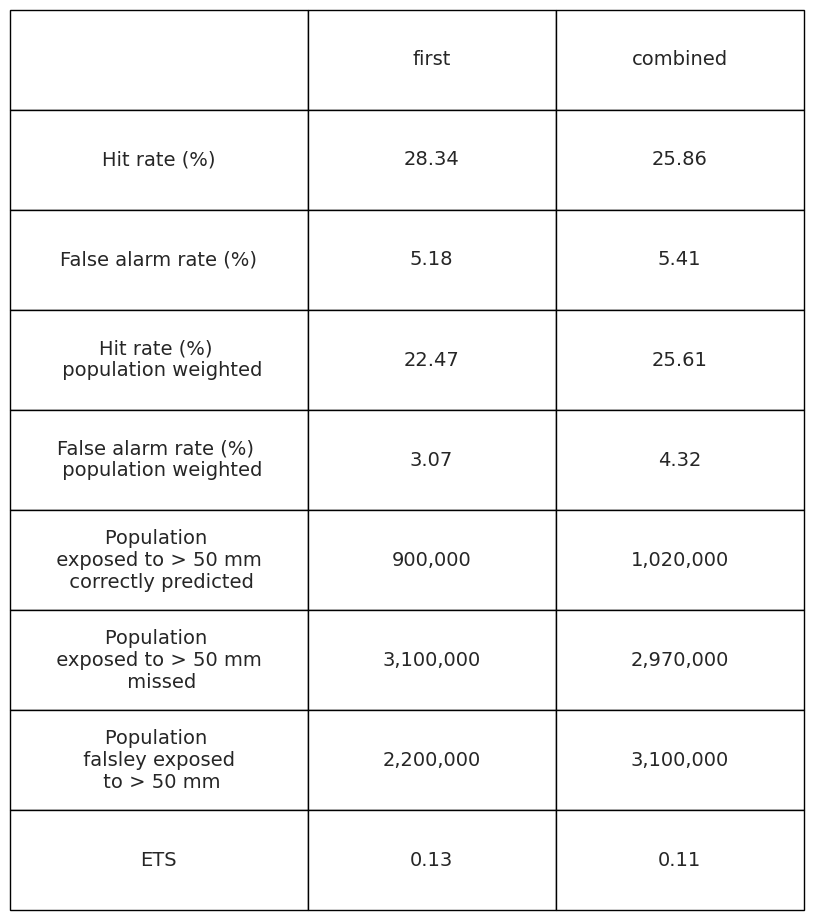

In [30]:
# False alarm rate is so low becuase there are a lot of cells with correct rejection

data = [["", "first", "combined"],
		["Hit rate (%)",f"{hit_rate*100:.2f}",f"{hit_rate2*100:.2f}"],
		["False alarm rate (%)", f"{false_alarm_rate*100:.2f}",f"{false_alarm_rate2*100:.2f}"],
        ["Hit rate (%) \n population weighted",f"{pop_hit_rate*100:.2f}",f"{pop_hit_rate2*100:.2f}"],
		["False alarm rate (%) \n population weighted",f"{pop_false_alarm_rate*100:.2f}",f"{pop_false_alarm_rate2*100:.2f}"],
		["Population \n exposed to > 50 mm \n correctly predicted",f"{round(pop_hit,-4):,.0f}",f"{round(pop_hit2,-4):,.0f}"],
        ["Population \n exposed to > 50 mm \n missed",f"{round(pop_miss,-4):,.0f}",f"{round(pop_miss2,-4):,.0f}"],
		["Population \n falsley exposed \n to > 50 mm",f"{round(pop_false_alarm,-4):,.0f}",f"{round(pop_false_alarm2,-4):,.0f}"],
		["ETS",f"{ETS:.2f}",f"{ETS2:.2f}"]]
# data = [[f'Row {i}, Col {j}' for j in range(4)] for i in range(6)]
print(data)
plt.axis('off')
table = plt.table(cellText=data, loc='center', cellLoc='center')
# Modify the table properties if needed
table.auto_set_font_size(False)
table.set_fontsize(14)
# table.set_edgecolor('white')
cell_dict = table.get_celld()
table.scale(1.5,6)
for i in range(9):
    cell_dict[(i,0)].set_width(0.6)
    
plt.savefig('figure_7b_table.png')


In [31]:
def superimpose_rain_onto_bigger_grid(storm,ntime,grid_x,grid_y,combo=False,truth=False):
    grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))

    if (combo == True) or (truth == True):
        grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1]))

    for t in range(ntime):
        s_lons = storm.storm_lons[t,:,:]
        s_lats = storm.storm_lats[t,:,:]
        
        if truth==True:
            storm_rain_truth = storm_truth.precipitation[t,:,:,0]

        Mlon = s_lons[-1,-1]
        mlon = s_lons[0,0]
        Mlat = s_lats[-1,-1]
        mlat = s_lats[0,0]
        Xspan = np.where((grid_x <= Mlon) & (grid_x >= mlon))[1][[0, -1]]
        Yspan = np.where((grid_y <= Mlat) & (grid_y >= mlat))[0][[0, -1]]

        # Create a selection
        sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]

        if truth == False:
            for i in range(20):
                storm_rain = storm.precipitation[t,:,:,i]
                grid_rain[t,sel[1],sel[0],i] = storm_rain
            
        else:
            grid_rain[t,sel[1],sel[0]] = storm_rain_truth
    
    return grid_rain
        

In [32]:
import glob,os
import sys
from io import StringIO

def run_silently(func,*args, **kwargs):
    sys.stdout = StringIO()  # Redirect stdout to a StringIO object
    func(*args, **kwargs)  # Call the function
    sys.stdout = sys.__stdout__  # Restore stdout




In [33]:
files = os.listdir('/user/home/al18709/work/event_sets/wgan_modular/')
sids = []
for file in files:
    if ('validation_1and2' in file) and ('critic' not in file) and ('extreme' not in file) and ('test' not in file):
        # sids.append(file[11:-3])
        sids.append(file[17:-3])
sids2 = []
for file in files:
    if ('validation_mraw' in file) and ('critic' not in file) and ('extreme' not in file) and ('test' not in file):
        sids2.append(file[11:-3])

In [34]:
sids = list(np.sort(sids))
print(list(np.sort(sids)))
print(list(np.sort(sids2)))
print(files)
sids = ['2006237N13298', '2020205N26272', '2020221N13262', '2020272N12257', '2020291N32305','2015152N12258', '2015183N13130', '2015184N08172', '2015209N07248', '2015226N15164', '2015263N14148', '2015270N27291', '2015273N12130', '2015344N07145', '2016075S11087', '2016242N24279', '2016244N21123', '2016255N12247', '2016296N11262', '2016341N08092', '2017114S08137', '2017122S13170', '2017127S18184', '2017203N14248', '2017253N14130', '2017260N12310', '2017280N32321', '2018004S08095', '2018079S08137', '2018184N10147', '2018202N21159', '2018204N15137', '2018244N14252', ]
sids = ['2006237N13298', '2020205N26272', '2020221N13262', '2020272N12257']

['1979002S04179', '1979083S15184', '1979174N07143', '1979230N11246', '1979252N16259', '1980069S12161', '1980208N23153', '1980210N17251', '1980219N15165', '1980219N15258', '1980236N13255', '1980270N13165', '1980323N04180', '1980330N36314', '1981069S12135', '1981166N11135', '1981207N22150', '1981225N16249', '1981227N18129', '1981244N30287', '1981297N11261', '1981306S03096', '1981307N17279', '1981319N07163', '1982005S10105', '1982022S26154', '1982024S18166', '1982087N04157', '1982169N09149', '1982188N09262', '1982199N11257', '1982227N09140', '1982242N13253', '1982253N10250', '1982257N20291', '1982262N11258', '1982283N17148', '1982304S10171', '1983141N07269', '1983186N04153', '1983221N13254', '1983285N09260', '1983321N11111', '1984011S18149', '1984186N16154', '1984189N11265', '1984207N29135', '1984239N16246', '1984267N31302', '1984313N14154', '1985168N05156', '1985199N08143', '1985202N13226', '1985212N22148', '1985236N23125', '1985240N08148', '1985240N20286', '1985244N14254', '1985249N1326

In [35]:
files = os.listdir('/user/home/al18709/work/event_sets/wgan_modular/')
sids = []
for file in files:
    if ('validation_mraw_' in file) and ('critic' not in file) and ('extreme' not in file) and ('global' not in file):
        sid = file[16:-3]
        sids.append(sid)

In [36]:
print(sids)

['2003269N12322', '2001212N10158', '1995235N13311', '1982253N10250', '1990031S09070', '1987266N16148', '1989053S14210', '1979083S15184', '1995256N15253', '1982169N09149', '2018300N25315', '1981166N11135', '1984189N11265', '1993241N14264', '1992212N05154', '2020272N12257', '2007242N13264', '2013348S10082', '1991210N11253', '2009215N10242', '2019210N11253', '1989142N11114', '1981207N22150', '2012230N21126', '2012169N29291', '2006364S12058', '1986252N06153', '1995260N15255', '2018202N21159', '2004264N13328', '1992302N06150', '1991256N13171', '2005013N05153', '1986254N22309', '1999218N12241', '1997009S16188', '2010331S07089', '1980236N13255', '1985240N08148', '1982005S10105', '2013257N15259', '2014259N11262', '2016244N21123', '2006311N16143', '1997021S16172', '1982304S10171', '1998096S13071', '2017253N14130', '2020205N26272', '1991099S10132', '2012279N15145', '1992247N10258', '2019255N15251', '1982199N11257', '2015152N12258', '1986179N11175', '1997152N06171', '2013262N14149', '2006193N1325

In [37]:
# now do for all storms and plot a box and whisker of all of them in the test set and extreme test set
# sids = ['2006237N13298']
fp = '/bp1/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
d = Dataset(fp, 'r')
lat = d.variables['lat'][:] #lat
lon = d.variables['lon'][:] #lon
population_file = '/user/home/al18709/work/population/ppp_2020_10km_Aggregated_final.nc'
population_count = xr.load_dataset(population_file)
# print(population_count)
data = population_count.population.values * 144
population = population_count.population.values * 144
pop = population_count * 144
pop_lats = population_count.lat
pop_lons = population_count.lon
grid_x_pop, grid_y_pop = np.meshgrid(pop_lons,pop_lats)

global_pop = pop.population.values
global_pop[global_pop == -inf] = 0
pop_new = global_pop[::-1, :]
blank_rows = np.zeros((120, pop_new.shape[1]))  # Create an array of zeros with the same number of columns as arr
pop_new_new = np.insert(pop_new, 0, blank_rows, axis=0)
global_pop_new = pop_new_new[:-120,:]

modular_hit_rates = np.zeros((len(sids),20))
modular_false_alarm_rates = np.zeros((len(sids),20))
modular_ETS = np.zeros((len(sids),20))
modular_pop_hits = np.zeros((len(sids),20))
modular_pop_misses = np.zeros((len(sids),20))
modular_pop_hit_rates = np.zeros((len(sids),20))
modular_pop_false_alarms = np.zeros((len(sids),20))
modular_pop_correct_rejections = np.zeros((len(sids),20))
modular_pop_false_alarm_rates = np.zeros((len(sids),20))

combo_hit_rates = np.zeros((len(sids)))
combo_false_alarm_rates = np.zeros((len(sids)))
combo_ETS = np.zeros((len(sids)))
combo_pop_hits = np.zeros((len(sids)))
combo_pop_misses = np.zeros((len(sids)))
combo_pop_hit_rates = np.zeros((len(sids)))
combo_pop_false_alarms = np.zeros((len(sids)))
combo_pop_correct_rejections = np.zeros((len(sids)))
combo_pop_false_alarm_rates = np.zeros((len(sids)))

combo2_hit_rates = np.zeros((len(sids)))
combo2_false_alarm_rates = np.zeros((len(sids)))
combo2_ETS = np.zeros((len(sids)))
combo2_pop_hits = np.zeros((len(sids)))
combo2_pop_misses = np.zeros((len(sids)))
combo2_pop_hit_rates = np.zeros((len(sids)))
combo2_pop_false_alarms = np.zeros((len(sids)))
combo2_pop_correct_rejections = np.zeros((len(sids)))
combo2_pop_false_alarm_rates = np.zeros((len(sids)))

max_hit_rates = np.zeros((len(sids)))
max_false_alarm_rates = np.zeros((len(sids)))
max_ETS = np.zeros((len(sids)))
max_pop_hits = np.zeros((len(sids)))
max_pop_misses = np.zeros((len(sids)))
max_pop_hit_rates = np.zeros((len(sids)))
max_pop_false_alarms = np.zeros((len(sids)))
max_pop_correct_rejections = np.zeros((len(sids)))
max_pop_false_alarm_rates = np.zeros((len(sids)))

ets_hit_rates = np.zeros((len(sids)))
ets_false_alarm_rates = np.zeros((len(sids)))
ets_ETS = np.zeros((len(sids)))
ets_pop_hits = np.zeros((len(sids)))
ets_pop_misses = np.zeros((len(sids)))
ets_pop_hit_rates = np.zeros((len(sids)))
ets_pop_false_alarms = np.zeros((len(sids)))
ets_pop_correct_rejections = np.zeros((len(sids)))
ets_pop_false_alarm_rates = np.zeros((len(sids)))



for j,sid in enumerate(np.sort(sids)):
    print('SID',sid)
    if sid in ['1999013S13164','2002297N09206','2015066S08170','1997021S16172','2010040S11185','2003068S14172','1988242N12215','1979002S04179','1979083S15184','1980069S12161',' 1982024S18166','1982024S18166','1993053S12161','2017127S18184']:
        continue
    
    storm = xr.open_dataset('/user/home/al18709/work/event_sets/wgan_modular/' + f'validation_mraw_{sid}.nc')
    storm_2 = xr.open_dataset('/user/home/al18709/work/event_sets/wgan_modular/' + f'validation_1and2_{sid}.nc')
    storm_scores_1 = np.load(tc_dir + f'validation_mraw_critic_{sid}.npy')
    storm_scores_2 = np.load(tc_dir + f'validation_1and2_critic_{sid}.npy')
    storm_scores_p = np.load(tc_dir_p + f'patchgan_critic_{sid}.npy')
    storm_truth = xr.open_dataset('/user/home/al18709/work/event_sets/truth/' + f'validation_{sid}.nc')
    
    ETS_scores = get_ets_scores(storm_2.precipitation.values,storm_truth.precipitation.values)
    # print(ETS_scores)

    lats = storm.storm_lats[0,:,:]
    lons = storm.storm_lons[0,:,:]
    if (np.sum(lons > 175) > 0) or (np.sum(lons < - 175)>0):
        continue
    ntime,_,_,_ = storm.precipitation.shape
    rain = storm.precipitation[0,:,:,0]
    rain2 = storm_2.precipitation[0,:,:,0]
    rain_truth = storm_truth.precipitation[0,:,:,0]

    grid_x,grid_y = find_storm_extent(lat,lon,storm)
    grid_rain_1 = superimpose_rain_onto_bigger_grid(storm,ntime,grid_x,grid_y,combo=False,truth=False)
    grid_rain_2 = superimpose_rain_onto_bigger_grid(storm_2,ntime,grid_x,grid_y,combo=False,truth=False)
    grid_rain_truth = superimpose_rain_onto_bigger_grid(storm_truth,ntime,grid_x,grid_y,combo=False,truth=True)

    accumulated_rain1 = np.sum(grid_rain_1[:,:,:,:],axis=0)
    accumulated_rain2 = np.sum(grid_rain_2[:,:,:,:],axis=0)
    accumulated_rain_truth = np.sum(grid_rain_truth,axis=0)

    # combo rain
    n_time_steps,n,m,_ = grid_rain_2.shape
    combo_rain = np.zeros((n_time_steps,n,m))
    combo2_rain = np.zeros((n_time_steps,n,m))
    max_rain = np.zeros((n_time_steps,n,m))
    ets_rain = np.zeros((n_time_steps,n,m))
    for t in range(n_time_steps):
        t_scores = storm_scores_2[t,:]
        best_score = np.argmax(t_scores)
        combo_rain[t,:,:] = grid_rain_2[t,:,:,best_score]
        t_scores_p = storm_scores_p[t,:]
        best_score_p = np.argmax(t_scores_p)
        combo2_rain[t,:,:] = grid_rain_2[t,:,:,best_score_p]
        max_idx = np.argmax(np.sum(grid_rain_2[t,:,:,:],axis=(0,1)))
        max_rain[t,:,:] = grid_rain_2[t,:,:,max_idx]
        ets_idx = np.argmax(ETS_scores[-1][t,:])
        ets_rain[t,:,:] = grid_rain_2[t,:,:,ets_idx]
        
    
    global_rain1 = np.zeros((pop.population.shape[0],pop.population.shape[1],20))
    global_rain2 = np.zeros((pop.population.shape[0],pop.population.shape[1],20))
    global_rain_combo = np.zeros((pop.population.shape[0],pop.population.shape[1]))
    global_rain_combo_p = np.zeros((pop.population.shape[0],pop.population.shape[1]))
    global_rain_max = np.zeros((pop.population.shape[0],pop.population.shape[1]))
    global_rain_ets = np.zeros((pop.population.shape[0],pop.population.shape[1]))
    global_rain_truth = np.zeros((pop.population.shape[0],pop.population.shape[1]))

    # superimpose rain onto bigger grid
    storm_lons = grid_x
    storm_lats = grid_y
    storm_rain_combo = np.sum(combo_rain,axis=0)
    storm_rain_combo2 = np.sum(combo2_rain,axis=0)
    storm_rain_max = np.sum(max_rain,axis=0)
    storm_rain_ets = np.sum(ets_rain,axis=0)

    Mlon = storm_lons[-1,-1]
    mlon = storm_lons[0,0]
    Mlat = storm_lats[-1,-1]
    mlat = storm_lats[0,0]
    grid_X,grid_Y = np.meshgrid(lon,lat)
    Xspan = np.where((grid_X <= Mlon) & (grid_X >= mlon))[1][[0, -1]]
    Yspan = np.where((grid_Y <= Mlat) & (grid_Y >= mlat))[0][[0, -1]]

    # Create a selection
    sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]
    global_rain1[sel[1],sel[0],:] = accumulated_rain1
    global_rain2[sel[1],sel[0],:] = accumulated_rain2
    global_rain_combo[sel[1],sel[0]] = storm_rain_combo
    global_rain_combo_p[sel[1],sel[0]] = storm_rain_combo2
    global_rain_max[sel[1],sel[0]] = storm_rain_max
    global_rain_ets[sel[1],sel[0]] = storm_rain_ets
    global_rain_truth[sel[1],sel[0]] = accumulated_rain_truth

    # hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = np.zeros((20)),np.zeros((20)),np.zeros((20)),np.zeros((20)),np.zeros((20)),np.zeros((20)),np.zeros((20)),np.zeros((20)),np.zeros((20))
    threshold = 50
    threshold = np.percentile(global_rain_truth[global_rain_truth > 0],90)
    print('threshold = ',threshold)
    for i in range(20):
        modular_hit_rates[j,i],modular_false_alarm_rates[j,i],modular_ETS[j,i],modular_pop_hits[j,i],modular_pop_misses[j,i],modular_pop_hit_rates[j,i],modular_pop_false_alarms[j,i],modular_pop_correct_rejections[j,i],modular_pop_false_alarm_rates[j,i] = ets(global_rain2[:,:,i],global_rain_truth,global_pop_new,threshold=threshold,silent=True)

    combo_hit_rates[j],combo_false_alarm_rates[j],combo_ETS[j],combo_pop_hits[j],combo_pop_misses[j],combo_pop_hit_rates[j],combo_pop_false_alarms[j],combo_pop_correct_rejections[j],combo_pop_false_alarm_rates[j] = ets(global_rain_combo,global_rain_truth,global_pop_new,threshold=threshold,silent=True)
    combo2_hit_rates[j],combo2_false_alarm_rates[j],combo2_ETS[j],combo2_pop_hits[j],combo2_pop_misses[j],combo2_pop_hit_rates[j],combo2_pop_false_alarms[j],combo2_pop_correct_rejections[j],combo2_pop_false_alarm_rates[j] = ets(global_rain_combo_p,global_rain_truth,global_pop_new,threshold=threshold,silent=True)
    max_hit_rates[j],max_false_alarm_rates[j],max_ETS[j],max_pop_hits[j],max_pop_misses[j],max_pop_hit_rates[j],max_pop_false_alarms[j],max_pop_correct_rejections[j],max_pop_false_alarm_rates[j] = ets(global_rain_max,global_rain_truth,global_pop_new,threshold=threshold,silent=True)
    ets_hit_rates[j],ets_false_alarm_rates[j],ets_ETS[j],ets_pop_hits[j],ets_pop_misses[j],ets_pop_hit_rates[j],ets_pop_false_alarms[j],ets_pop_correct_rejections[j],ets_pop_false_alarm_rates[j] = ets(global_rain_ets,global_rain_truth,global_pop_new,threshold=threshold,silent=True)

    
        

SID 1979002S04179
SID 1979083S15184
SID 1979174N07143


/tmp/ipykernel_204363/174226476.py:10: RuntimeWarning: overflow encountered in multiply
  data = population_count.population.values * 144
/tmp/ipykernel_204363/174226476.py:11: RuntimeWarning: overflow encountered in multiply
  population = population_count.population.values * 144


threshold =  95.25000115953895
SID 1979230N11246
threshold =  55.37500187846128


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1979252N16259
threshold =  64.68750223396917
SID 1980069S12161
SID 1980208N23153
threshold =  160.87499863139666


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1980210N17251
threshold =  20.500000273637347


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1980219N15165
threshold =  69.75000028409818


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1980219N15258
threshold =  71.68749894288335


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1980236N13255
threshold =  45.687501758021824


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1980270N13165
threshold =  110.68749598693253


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1980323N04180
threshold =  65.37500000812601
SID 1980330N36314
threshold =  7.1875004025464895


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)


SID 1981069S12135
threshold =  57.749999484894865
SID 1981166N11135
threshold =  96.75000104159307
SID 1981207N22150
threshold =  47.75000161921341
SID 1981225N16249
threshold =  11.375000266478317


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1981227N18129
threshold =  189.2124976303382
SID 1981244N30287
threshold =  59.12499771315414


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)


SID 1981297N11261
threshold =  89.63125150574248
SID 1981306S03096
threshold =  128.06249948525956


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1981307N17279
threshold =  56.125002751408246
SID 1981319N07163
threshold =  94.68749775768727
SID 1982005S10105
threshold =  86.24999789098422


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1982022S26154
threshold =  204.23750066878162


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1982024S18166
SID 1982087N04157
threshold =  90.43749853259425
SID 1982169N09149
threshold =  99.4374976275827
SID 1982188N09262
threshold =  39.31249966580535


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1982199N11257
threshold =  39.4999993579743


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1982227N09140
threshold =  103.87500008449854
SID 1982242N13253
threshold =  39.375001640434476


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1982253N10250
threshold =  68.43750021946472


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1982257N20291
threshold =  43.62500138122138
SID 1982262N11258
threshold =  87.37499729968907


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1982283N17148
threshold =  72.81249963442022
SID 1982304S10171
threshold =  185.37500062853925
SID 1983141N07269
threshold =  226.68750159257306
SID 1983186N04153
threshold =  137.2500010751297
SID 1983221N13254
threshold =  36.075000498387794
SID 1983285N09260
threshold =  66.99999895893588
SID 1983321N11111
threshold =  311.55000176841816


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1984011S18149
threshold =  136.36249913945124


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1984186N16154
threshold =  111.0625000586811


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1984189N11265
threshold =  97.43749799545805
SID 1984207N29135
threshold =  70.26875071966226
SID 1984239N16246
threshold =  47.31249977660399


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1984267N31302
threshold =  29.50000061385816


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)


SID 1984313N14154
threshold =  116.06250179193374


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)


SID 1985168N05156
threshold =  101.17499817201735
SID 1985199N08143
threshold =  91.87500346219015
SID 1985202N13226
threshold =  72.06249575196097


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1985212N22148
threshold =  108.68749885742626
SID 1985236N23125
threshold =  64.3124963656677
SID 1985240N08148
threshold =  109.74999915149229
SID 1985240N20286
threshold =  116.93749740413489
SID 1985244N14254
threshold =  68.53125187692288


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1985249N13265
threshold =  47.2500011228347
SID 1985268N16126
threshold =  88.21249915184701
SID 1986169N07152
threshold =  43.99999881562545
SID 1986176N11262
threshold =  64.00000076606298


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1986179N11175
threshold =  160.0000005520608
SID 1986252N06153
threshold =  161.34999760872836
SID 1986254N22309
threshold =  74.74999969921986


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1986270N05178
threshold =  103.43749418982384
SID 1986360S13195
threshold =  179.5875019950862
SID 1987188N10151
threshold =  106.12499783443977
SID 1987226N13241
threshold =  54.0625006716543


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1987231N10159
threshold =  140.81250322377667
SID 1987242N13257
threshold =  54.50000004275707


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1987258N15253
threshold =  22.687499900620047
SID 1987266N16148
threshold =  102.56250183548956


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1988242N12215
SID 1988242N13262
threshold =  89.37499943944874
SID 1988285N09318
threshold =  73.87500408509689
SID 1989006S15044
threshold =  209.77499820084222
SID 1989037S16164
threshold =  220.04375034967163
SID 1989044S12102
threshold =  169.1249997469337


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1989053S14210
threshold =  63.437500163046195


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)


SID 1989142N11114
threshold =  114.06249829611419
SID 1989153N04144
threshold =  142.5625025654245
SID 1989190N20160
threshold =  100.62499778456069
SID 1989212N23270
threshold =  34.943750268602614
SID 1989230N14338
threshold =  46.18750192886802


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1989238N17339
threshold =  58.56250223346733


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)


SID 1989238N22253
threshold =  35.500000180682974
SID 1989254N13340
threshold =  76.43750179260142
SID 1989271N12142
threshold =  85.12499695603054
SID 1989286N19268
threshold =  44.18750137936717
SID 1990031S09070
threshold =  151.43749371137775


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1990062S13091
threshold =  107.15625079380887


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1990154N11260
threshold =  39.97499959189561


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1990201N12254
threshold =  76.81250081368172


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1990251N06171
threshold =  124.49999828279526
SID 1990253N12248
threshold =  60.31250279019606


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1991099S10132
threshold =  148.75000013007164


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)


SID 1991210N11253
threshold =  55.749999536733874


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1991220N20160
threshold =  34.81250199447403
SID 1991251N12138
threshold =  76.68124940865806
SID 1991256N13171
threshold =  110.12499827274645
SID 1991268N12264
threshold =  99.87499960006448


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1991277N13251
threshold =  47.93750106059781
SID 1991289N06156
threshold =  158.93749998649585
SID 1991352S08066
threshold =  142.74999879745317


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1992185N13265
threshold =  67.43750150184954
SID 1992212N05154
threshold =  92.0625010921983
SID 1992230N11325
threshold =  31.562501945268977
SID 1992247N10258
threshold =  73.49999980314605


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1992262N10262
threshold =  93.06249726823425


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1992262N34301
threshold =  44.187498907806166


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1992266N30327
threshold =  56.23749874614553
SID 1992297N26299
threshold =  36.6875011952157


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1992302N06150
threshold =  131.12500358618655


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)


SID 1993016S06091
threshold =  117.06250051256912


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1993053S12161
SID 1993083S12181
SID 1993164N04160
threshold =  122.8750020991971
SID 1993229N10159
threshold =  113.62500297387798
SID 1993241N14264
threshold =  45.812500730494136
SID 1993249N12253
threshold =  95.43749981649677


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1993261N11131
threshold =  104.21249979175069
SID 1993262N27298
threshold =  31.43750034748501


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1993263N11168
threshold =  106.12499870919748


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1993331N05172
threshold =  74.49999790850981
SID 1994022S12113
threshold =  51.99999833604787


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1994241N14236
threshold =  26.56250068287656


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1994251N10180
threshold =  160.94375327802544
SID 1994306N23313
threshold =  25.750000298052445


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1995059S11155
threshold =  70.31249923216632


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1995064S13042
threshold =  135.66249883694005
SID 1995189N11257
threshold =  72.87500206525333


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1995206N15133
threshold =  182.93749433078023
SID 1995212N22287
threshold =  69.93750022050575
SID 1995235N13311
threshold =  73.93750240269962
SID 1995241N11333
threshold =  88.93749384438712
SID 1995256N15253
threshold =  51.937499315380826
SID 1995260N15255
threshold =  80.75000156415005
SID 1995277N07141
threshold =  128.0062520530395
SID 1995281N14278
threshold =  154.62500158621546
SID 1995287N08163
threshold =  83.37499949469722


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1996021S16152
threshold =  71.37500111307787
SID 1996057S12074
threshold =  74.3749982015542


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1996186N19156
threshold =  99.02499959431228
SID 1996208N20165
threshold =  127.5624997449373


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1996233N12340
threshold =  83.4374996349366
SID 1996254N13138
threshold =  207.5749963496305
SID 1996274N13261
threshold =  126.93750092098863
SID 1996289S05093
threshold =  39.50000129529917


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1996291N17168
threshold =  64.06250125896808


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1996319N11283
threshold =  86.00000216758585
SID 1997009S16188
threshold =  72.87499467266727
SID 1997021S16172
SID 1997042S13096
threshold =  81.8749972241698


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1997099N06153
threshold =  140.93750159887406
SID 1997152N06171
threshold =  83.43750130383532


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)


SID 1997156S11192
SID 1997167N06162
threshold =  96.812500795017
SID 1997187N13250
threshold =  69.84375147680663


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1997196N08142
threshold =  192.6749965721282
SID 1997252N10171
threshold =  108.43750238409626
SID 1998079S10145
threshold =  64.62500056699413


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)


SID 1998096S13071
threshold =  213.1374965013667


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1998210N14263
threshold =  67.31249877328274


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1998235N17131
threshold =  150.8124982950833
SID 1998264N10343
threshold =  46.37500219015611


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1998285N12149
threshold =  97.25000123296977
SID 1999013S13164
SID 1999208N06139
threshold =  87.62499883237341
SID 1999218N12241
threshold =  48.31249961953456


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1999236N22292
threshold =  165.5000056338059
SID 1999315N13127
threshold =  44.43750070584366


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2000006S15164
SID 2000024S12100
threshold =  26.500000017687896


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2000055S23227
threshold =  81.10625007480574
SID 2000142N12262
threshold =  77.1875013792874


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2000185N15117
threshold =  136.3000008349286
SID 2000214N22155
threshold =  68.12500295121716
SID 2000237N08138
threshold =  99.12500147128335
SID 2000273N16277
threshold =  76.31250058393468
SID 2000333S11140
threshold =  128.08750018499455
SID 2001180N15118
threshold =  112.31249648477628
SID 2001212N10158
threshold =  77.12499916643657


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2001245N13326
threshold =  50.51875298191943
SID 2001248N23125
threshold =  99.50000076625967
SID 2001255N26276
threshold =  73.50000159782617
SID 2001361N01106
threshold =  45.56250038946653
SID 2002017S07078
threshold =  128.43750229415542
SID 2002033S13121
threshold =  157.68749950365714
SID 2002063S11066
threshold =  133.87499750050662
SID 2002234N13253
threshold =  62.31250114888055


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2002297N09206
SID 2002335N05166
threshold =  145.61874568712858
SID 2003056S21042
threshold =  119.4999979316841
SID 2003068S14172
SID 2003212N09150
threshold =  131.81250562208984
SID 2003247N10153
threshold =  75.81250077881079
SID 2003269N12322
threshold =  55.7500001739966


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2003275N16252
threshold =  47.875000984390034


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2004201N14247
threshold =  31.937500624267845


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2004227N15141
threshold =  64.18749999929598
SID 2004264N13328
threshold =  62.81249917463302


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2004357S06095
threshold =  124.71874972750692


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2005003S09177
threshold =  109.50000476590324
SID 2005013N05153
threshold =  54.687499020493924


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)


SID 2005017S09061
threshold =  57.23124931371272
SID 2005032S14195
threshold =  117.95000391428988
SID 2005138N10265
threshold =  99.38125044333572
SID 2005186N12299
threshold =  70.50000267995743
SID 2005192N11318
threshold =  45.125001147201125
SID 2005232N13263
threshold =  70.49999838661145
SID 2005245N19315
threshold =  74.74999959999502


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2005249N26281
threshold =  92.3062483324308
SID 2005255N15246
threshold =  92.00000003596605


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2005261N14252
threshold =  54.58124907430345


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2005271N17255
threshold =  44.56249864815172
SID 2005275N19274
threshold =  63.87500202824349
SID 2006075S14185
threshold =  139.3875013288863


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2006078S12119
threshold =  88.3750027606046


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2006106S10153
threshold =  175.68750098596243
SID 2006128N09138
threshold =  219.91875118282462
SID 2006180N06140
threshold =  148.66875156271212
SID 2006193N13258
threshold =  58.62500079649327


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2006228N13247
threshold =  73.49999906162178


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2006237N13298
threshold =  51.62499822518451
SID 2006254N20306
threshold =  33.250001904624966


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)


SID 2006257N16259
threshold =  81.06250139176672
SID 2006311N16143
threshold =  39.1249982529817
SID 2006364S12058
threshold =  86.49999921468495
SID 2007043S11071
threshold =  62.750001554061264
SID 2007050S16079
threshold =  199.137501385968
SID 2007090N06158
threshold =  65.25000003686172
SID 2007208N20155
threshold =  81.81250048998348
SID 2007240N17153
threshold =  118.15624995957575
SID 2007242N13264
threshold =  82.06250282793066
SID 2007314N10093
threshold =  101.00000145677852
SID 2008023S10050
threshold =  142.12500405136498
SID 2008037S10055
threshold =  195.71874806356197
SID 2008104N08128
threshold =  105.74374535810696
SID 2008194N11266
threshold =  42.64375081359494
SID 2008262N16142
threshold =  114.93749728597945
SID 2008268N12140
threshold =  123.81249968991135
SID 2008278N13261
threshold =  76.43750086139094
SID 2009074S10129
threshold =  40.43750089874805


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2009123N10111
threshold =  93.87500523174415
SID 2009215N10242
threshold =  67.3749984344658


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2009238N20151
threshold =  64.31250197898235
SID 2009270N10148
threshold =  122.8437508392548
SID 2010019S11123
threshold =  40.00000008833132
SID 2010040S11185
SID 2010080S06089
threshold =  82.3749989892602


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2010172N08272
threshold =  69.31250256424656
SID 2010234N11329
threshold =  73.24999837155013


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2010263N15328
threshold =  38.481249581309164


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)


SID 2010279N22293
threshold =  38.31250114152843


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2010331S07089
threshold =  93.35000366747308


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2011013S15151
threshold =  52.43749827847002
SID 2011199N10271
threshold =  55.68750188193859
SID 2011233N15301
threshold =  121.8125089033171
SID 2011250N12324
threshold =  42.875001908688844
SID 2011253N20145
threshold =  104.75000409583289
SID 2011270N18139
threshold =  77.99999987177881
SID 2012018S16041
threshold =  211.31250181951745
SID 2012024S15116
threshold =  137.61874713108188


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2012141N11148
threshold =  89.3124997708194
SID 2012142N09262
threshold =  98.1249982512137
SID 2012169N29291
threshold =  16.312500540227344


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2012186N12255
threshold =  71.56250243249433


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2012230N21126
threshold =  112.62500022025519
SID 2012246N29323
threshold =  45.37500058822188


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2012279N15145
threshold =  153.75000068422557
SID 2012288N14248
threshold =  68.87500065559874
SID 2013046S20042
threshold =  81.3499999498391
SID 2013052S13126
threshold =  230.37499897148825
SID 2013178N09133
threshold =  50.71875047875835
SID 2013180N11256
threshold =  28.750000935662328
SID 2013257N15259
threshold =  99.2687552382944
SID 2013262N14149
threshold =  113.96875220387444
SID 2013306N07162
threshold =  89.06249718396057
SID 2013348S10082
threshold =  101.87500373542422


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2014117N10145
threshold =  79.56250057015023


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)


SID 2014197N10137
threshold =  111.24999769360808
SID 2014214N13249
threshold =  43.2499997668123


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2014259N11262
threshold =  75.00000289638425
SID 2014279N11096
threshold =  118.1999996231134
SID 2014284N10231
threshold =  48.31249762124758
SID 2014319S06066
threshold =  73.37500086436518


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2014334N02156
threshold =  117.53750134826024
SID 2015030S16161
threshold =  80.93749865412661
SID 2015038N08158
threshold =  90.11249985857143


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2015066S08170
SID 2015117S12115
threshold =  86.3124989777451
SID 2015152N12258
threshold =  151.24999803248068


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2015183N13130
threshold =  159.62499924006747
SID 2015184N08172
SID 2015209N07248
threshold =  88.97499936238225


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2015226N15164
threshold =  147.06249659392697


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2015263N14148
threshold =  147.9375039814168
SID 2015270N27291
threshold =  87.37500264069287
SID 2015273N12130
threshold =  85.06249989034545
SID 2015344N07145
threshold =  90.68750464216993
SID 2016075S11087
threshold =  141.28125119911658


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2016242N24279
threshold =  108.68749600324976
SID 2016244N21123
threshold =  62.35624994598692
SID 2016255N12247
threshold =  43.125000274851466


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2016296N11262
threshold =  47.43750032158967


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2016341N08092
threshold =  71.56249928045234
SID 2017114S08137
threshold =  56.98749934537294
SID 2017122S13170
threshold =  169.8750007479595
SID 2017127S18184
SID 2017203N14248
threshold =  64.9500015660974


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2017253N14130
threshold =  94.0000010515261
SID 2017260N12310
threshold =  83.62499644903238
SID 2017280N32321
threshold =  44.624998951697854
SID 2018004S08095
threshold =  69.00000023373909


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2018079S08137
threshold =  91.38125130491116
SID 2018184N10147
threshold =  88.68749881885302
SID 2018202N21159
threshold =  70.81250146760445


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2018204N15137
threshold =  65.31249968471676
SID 2018244N14252
threshold =  33.250001650515664


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2018280N18273
threshold =  68.49999870330612
SID 2018300N25315
threshold =  47.500000165642014


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2018348S08093
threshold =  114.8500058959613


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2019210N11253
threshold =  58.12499914878511


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2019216N16147
threshold =  235.83750138676032
SID 2019255N15251
threshold =  72.1249999939996


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2019296N15066
threshold =  89.37500215237829
SID 2019302N11118
threshold =  111.87499815098191
SID 2020205N26272
threshold =  40.499998513540305
SID 2020221N13262
threshold =  30.562498319243424
SID 2020272N12257
threshold =  80.68750166769581


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2020291N32305
threshold =  62.62499869383198


/tmp/ipykernel_204363/3175725858.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_204363/3175725858.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


In [38]:
print(global_rain_truth)
print(accumulated_rain_truth)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 3.00000026 3.25000011 0.        ]
 [0.         0.         0.         ... 3.00000026 3.25000011 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


/tmp/ipykernel_204363/1800069910.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,0].set_xticklabels(labels, rotation=90)


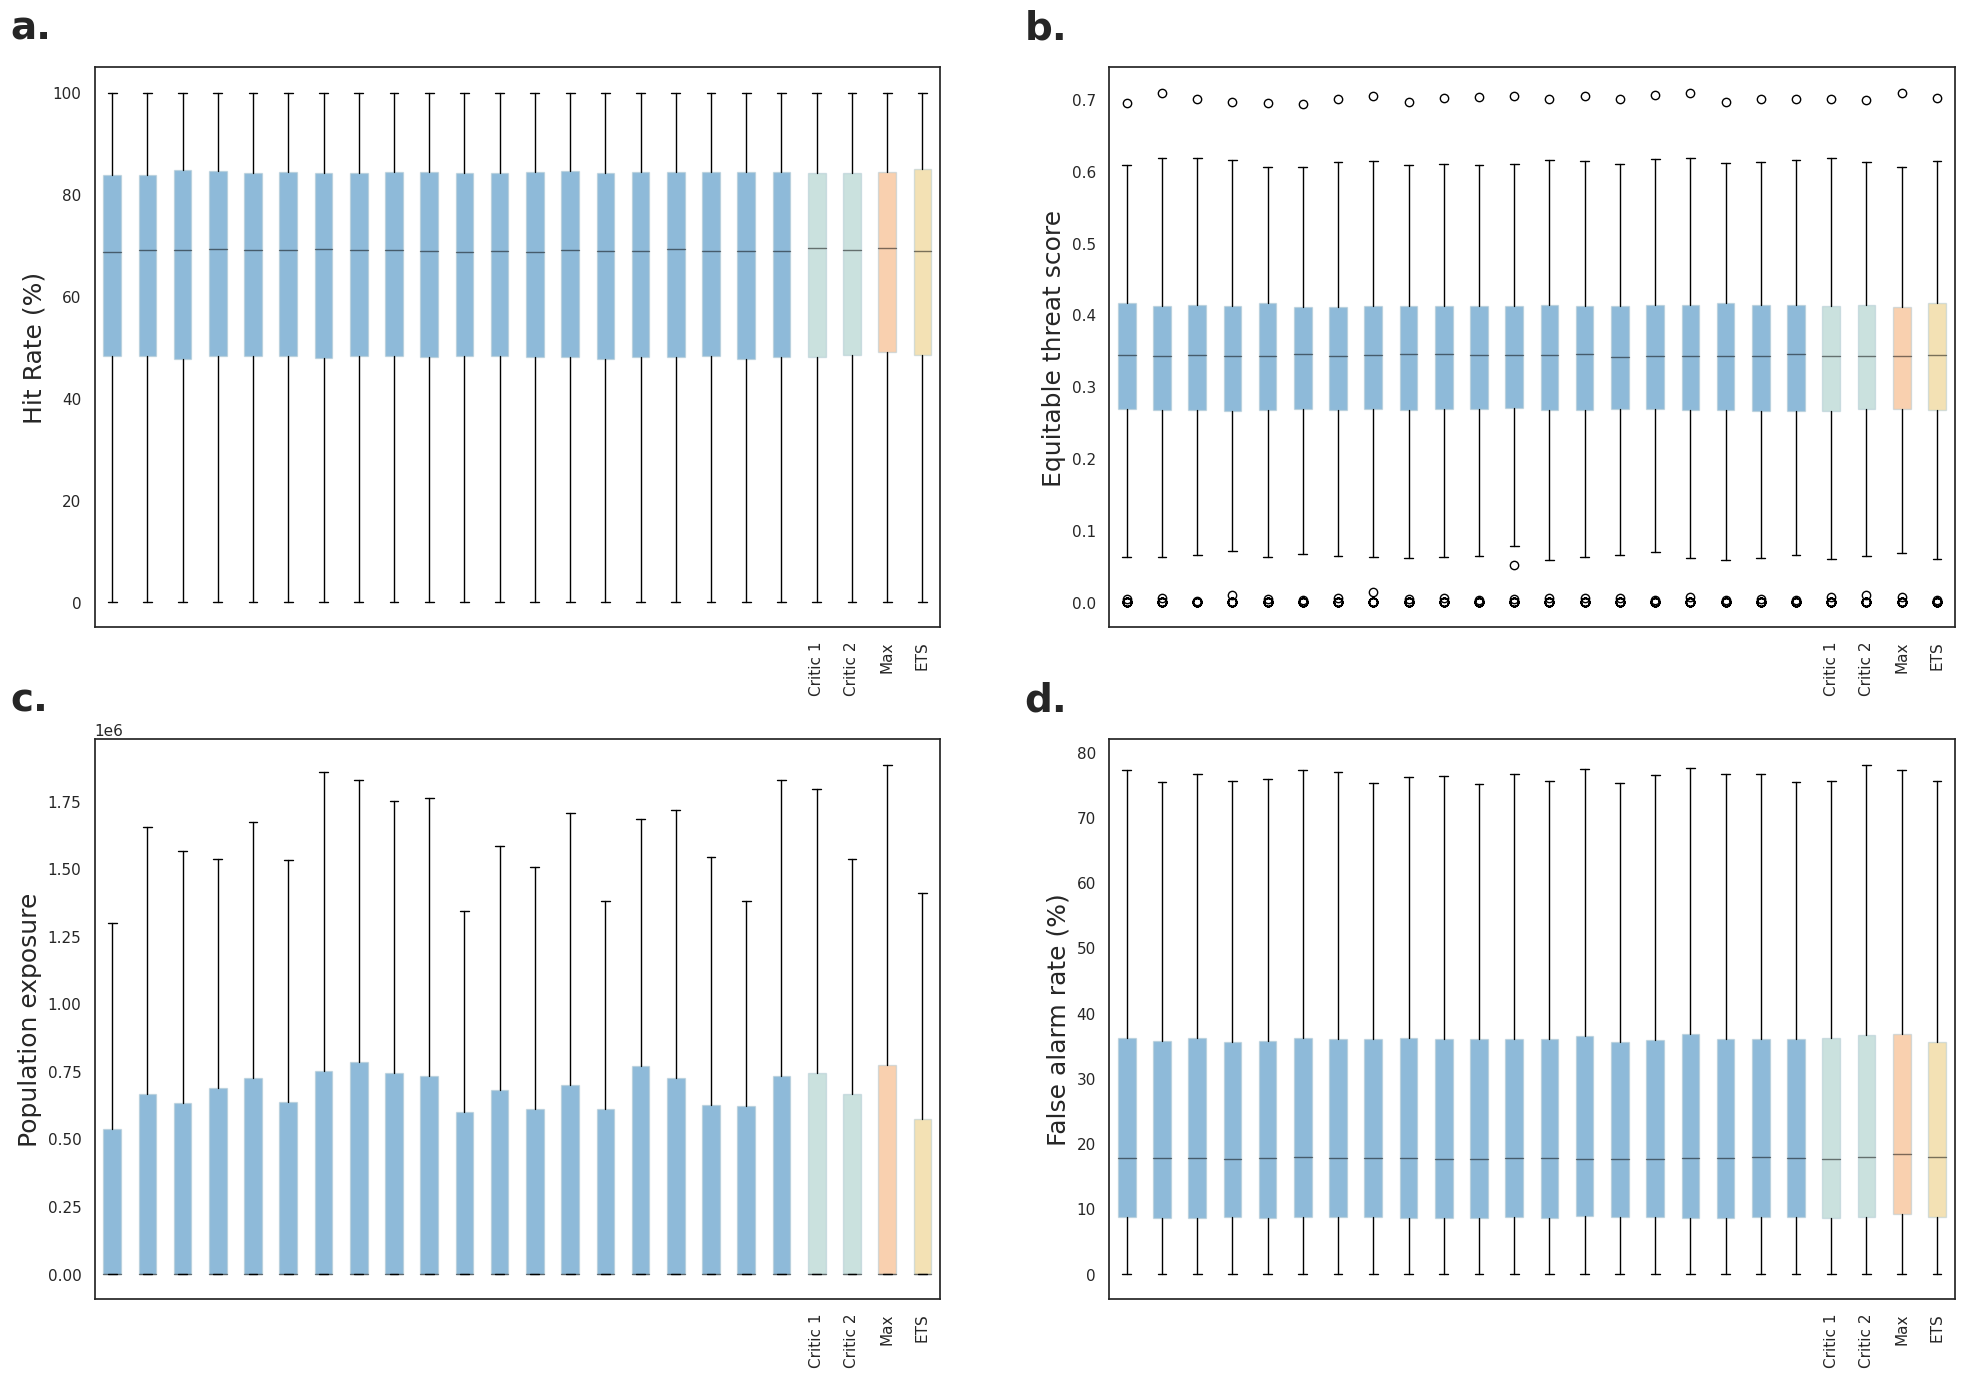

In [39]:
# Sample data
categories = ['Ensemble member {}'.format(i) for i in range(1, 24)]
hit_rates = np.random.uniform(0, 100, size=(20, 22))  # Example hit rates, replace with your actual data

hit_rates = (np.concatenate((modular_hit_rates,np.expand_dims(combo_hit_rates,axis=1),np.expand_dims(combo2_hit_rates,axis=1),np.expand_dims(max_hit_rates,axis=1),np.expand_dims(ets_hit_rates,axis=1)),axis=1)*100)

ETSs = np.concatenate((modular_ETS,np.expand_dims(combo_ETS,axis=1),np.expand_dims(combo2_ETS,axis=1),np.expand_dims(max_ETS,axis=1),np.expand_dims(ets_ETS,axis=1)),axis=1)

pop_hits = np.concatenate((modular_pop_hits,np.expand_dims(combo_pop_hits,axis=1),np.expand_dims(combo2_pop_hits,axis=1),np.expand_dims(max_pop_hits,axis=1),np.expand_dims(ets_pop_hits,axis=1)),axis=1)

false_alarm_rate = np.concatenate((modular_false_alarm_rates,np.expand_dims(combo_false_alarm_rates,axis=1),np.expand_dims(combo2_false_alarm_rates,axis=1),np.expand_dims(max_false_alarm_rates,axis=1),np.expand_dims(ets_false_alarm_rates,axis=1)),axis=1)*100

palette = ['blue'] * 20 + ['red'] * 4

# Create box plots using Seaborn
# sns.boxplot(data=data, palette=palette)

fig, axs = plt.subplots(2, 2, figsize=(24, 16))
bplt = axs[0,0].boxplot(hit_rates, patch_artist=True, medianprops=dict(color='black', alpha=0.5), boxprops=dict(color='#aec7d1', alpha=0.5))
bplt['boxes'][-4].set_facecolor('#97c4bf')
bplt['boxes'][-3].set_facecolor('#97c4bf')
bplt['boxes'][-2].set_facecolor('#f4a261')
bplt['boxes'][-1].set_facecolor('#e9c46a')
axs[0,0].set_ylabel('Hit Rate (%)',fontsize=18)
axs[1,0].set_ylabel('Population exposure',fontsize=18)
axs[1,1].set_ylabel('False alarm rate (%)',fontsize=18)
# axs[0,0].set_title('Hit Rates')

# Set tick labels for the last 4 ticks as words vertically
labels = ['']*20
labels += ['Critic 1','Critic 2','Max','ETS']
axs[0,0].set_xticklabels(labels, rotation=90)

bplt = axs[0,1].boxplot(ETSs, vert=True,patch_artist=True, medianprops=dict(color='black', alpha=0.5), boxprops=dict(color='#aec7d1', alpha=0.5))
axs[0,1].set_ylabel('Equitable threat score',fontsize=18)
# axs[0,1].set_title('ETS')
bplt['boxes'][-4].set_facecolor('#97c4bf')
bplt['boxes'][-3].set_facecolor('#97c4bf')
bplt['boxes'][-2].set_facecolor('#f4a261')
bplt['boxes'][-1].set_facecolor('#e9c46a')
axs[1,0].set_xticklabels(labels, rotation=90)

bplt = axs[1,0].boxplot(pop_hits, vert=True,showfliers=False,patch_artist=True, medianprops=dict(color='black', alpha=0.5), boxprops=dict(color='#aec7d1', alpha=0.5))

# axs[1,0].set_title('pop hits')
bplt['boxes'][-4].set_facecolor('#97c4bf')
bplt['boxes'][-3].set_facecolor('#97c4bf')
bplt['boxes'][-2].set_facecolor('#f4a261')
bplt['boxes'][-1].set_facecolor('#e9c46a')
axs[0,1].set_xticklabels(labels, rotation=90)

bplt = axs[1,1].boxplot(false_alarm_rate, vert=True,showfliers=False,patch_artist=True, medianprops=dict(color='black', alpha=0.5), boxprops=dict(color='#aec7d1', alpha=0.5))

# axs[1,1].set_title('false alarm rate')
bplt['boxes'][-4].set_facecolor('#97c4bf')
bplt['boxes'][-3].set_facecolor('#97c4bf')
bplt['boxes'][-2].set_facecolor('#f4a261')
bplt['boxes'][-1].set_facecolor('#e9c46a')

axs[1,1].set_xticklabels(labels, rotation=90)


axs[0,0].text(-0.1, 1.05, 'a.', transform=axs[0,0].transAxes, size=28, weight='bold')
axs[0,1].text(-0.1, 1.05, 'b.', transform=axs[0,1].transAxes, size=28, weight='bold')
axs[1,0].text(-0.1, 1.05, 'c.', transform=axs[1,0].transAxes, size=28, weight='bold')
axs[1,1].text(-0.1, 1.05, 'd.', transform=axs[1,1].transAxes, size=28, weight='bold')

# Rotate x-axis labels vertically
# plt.xticks(rotation=90)
# plt.xticks(range(1, 23), categories)

plt.savefig('ensemble_combined_90_mwgan12.png',bbox_inches='tight')

In [40]:
meta = pd.read_csv('/user/work/al18709/tc_data_mswep_40/scalar_wgan_extreme_valid_meta_with_dates.csv')

In [41]:
print(meta)

      Unnamed: 0.1  Unnamed: 0            sid  centre_lat  centre_lon  \
0                0           0  1979275N06159      6.4500     151.850   
1                1           1  1979275N06159      6.5137     151.962   
2                2           2  1979275N06159      6.6429     152.020   
3                3           3  1979275N06159      6.7946     152.128   
4                4           4  1979275N06159      6.9933     152.242   
...            ...         ...            ...         ...         ...   
5338          5338        5338  2019243N06136     36.7291     124.944   
5339          5339        5339  2019243N06136     37.9000     125.225   
5340          5340        5340  2019243N06136     39.2664     125.670   
5341          5341        5341  2019243N06136     40.8333     126.340   
5342          5342        5342  2019243N06136     42.5999     127.219   

                     date  
0     1979-10-07 12:00:00  
1     1978-01-01 00:00:00  
2     1978-01-01 00:00:00  
3     1978-